## 1, ライブラリをインポート

In [1]:
import os, io, re
import cv2
import glob
import random
import pickle
import shap
import copy
import optuna
import graphviz
import pydotplus
import lightgbm as lgb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn-bright')
font = {'family' : 'sans-serif'}
plt.rc('font', **font)

In [2]:
from tqdm import tqdm
from PIL import Image
from functools import partial
from pycm import ConfusionMatrix
from numpy import argmax

from sklearn.externals.six import StringIO
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn import tree

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import *

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8203215529441653024,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4930941747
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10430908651896819273
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_list

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

In [34]:
#レーダーチャート関数
def plot_polar(labels, values, values2 = np.array([])):
    angles = np.linspace(0, 2 * np.pi , len(labels) + 1, endpoint=True)
    fig = plt.figure(figsize=(8, 8), facecolor='w')
    ax = fig.add_subplot(111, polar=True)
    
    #2値の場合
    for i in range(6,10):
        values[i] = values[i] * 5
        if len(values2) != 0:
            values2[i] = values2[i] * 5
    
    values = np.concatenate((values, [values[0]]))  # 閉じた多角形にする
    ax.plot(angles, values, 'o-', label="True", color=color_list[2], alpha=0.8)  # 外枠
    ax.fill(angles, values, color=color_list[2], alpha=0.2)  # 塗りつぶし
    
    if len(values2) != 0:
        values2 = np.concatenate((values2, [values2[0]]))  # 閉じた多角形にする
        ax.plot(angles, values2, 's-', label="Pred", color=color_list[3], alpha=0.8)  # 外枠2
        ax.fill(angles, values2, color=color_list[3], alpha=0.2)  # 塗りつぶし
    
    ax.legend()
    ax.set_thetagrids(angles[:-1] * 180 / np.pi , labels)  # 軸ラベル
    ax.set_rlim(0 ,5) # 範囲
    ax.spines['polar'].set_visible(False) # 軸の削除
    plt.tight_layout() # 重なり防止
    plt.show()

In [35]:
#plot_polar(["front","close","background","focus","position","brightness","plural","natural light","one's gaze","no flash"], y_valid[i], np.squeeze(X2.loc[[i]].values))

## 2, 学習データを前処理

In [7]:
for i,file in enumerate(os.listdir("./csv2/")):
    if i == 0:
        df = pd.read_csv("./csv2/" + file, encoding="SJIS")
    else:
        df = pd.concat([df,pd.read_csv("./csv2/" +file, encoding="SJIS")])

#カラムが日本語だと処理しづらいため英語に変換
df.columns = ["image","front","close","background",
              "focus","cute","position","brightness",
              "plural","care","natural light","one's gaze","no flash"]
df = df.reset_index(drop=True)
df["image"] = [("00000" + i) for i in df["image"]]
df

image  front  close  background  focus  cute  position  \
0    00000025_018.jpg      5      5           5      4     2         4   
1    00000025_022.jpg      5      4           3      4     3         4   
2    00000025_029.jpg      3      3           3      5     4         3   
3    00000026_001.jpg      5      3           2      4     4         3   
4    00000026_008.jpg      5      3           4      5     3         3   
..                ...    ...    ...         ...    ...   ...       ...   
595  00000056_022.jpg      4      4           3      4     2         5   
596  00000057_001.jpg      5      2           3      4     4         5   
597  00000058_005.jpg      4      4           4      4     4         4   
598  00000058_010.jpg      4      2           3      5     5         5   
599  00000058_011.jpg      4      4           4      3     5         4   

     brightness  plural  care  natural light  one's gaze  no flash  
0             2       0     0              1           1         1  
1             2       0     0              1           1         0  
2             2       0     1              1           1         1  
3             3       0     1              0           1         1  
4             3       0     0              1           1         1  
..          ...     ...   ...            ...         ...       ...  
595           3       0     0              1           1         0  
596           3       0     0              1           1         1  
597           3       0     0              0           1         1  
598           3       0     1              1           1         1  
599           4       0     1              0           1         1  

[600 rows x 13 columns]

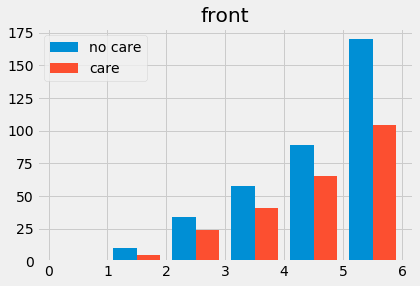

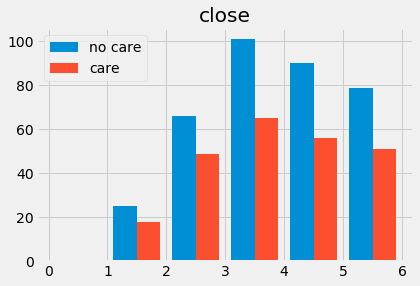

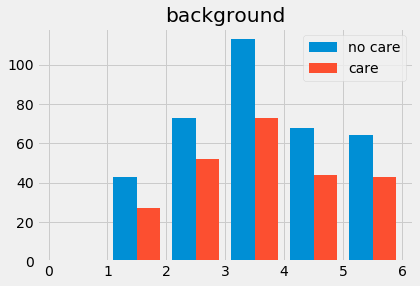

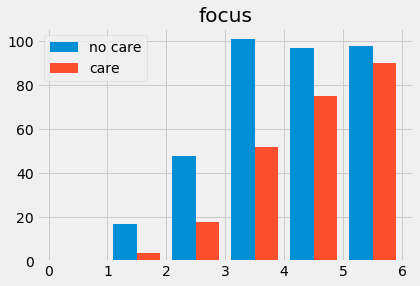

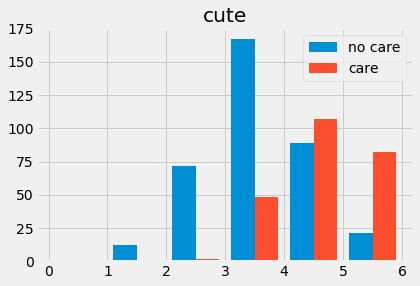

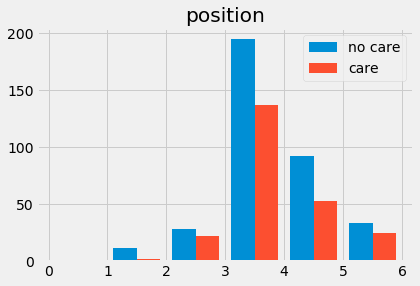

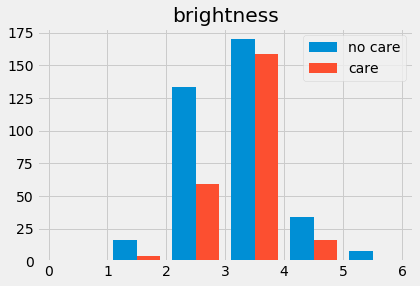

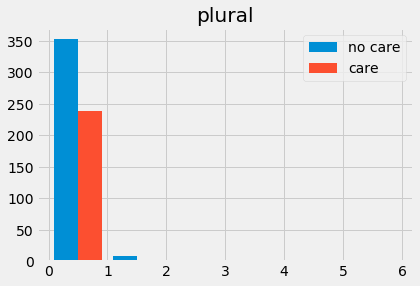

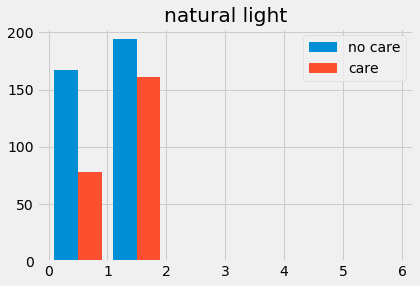

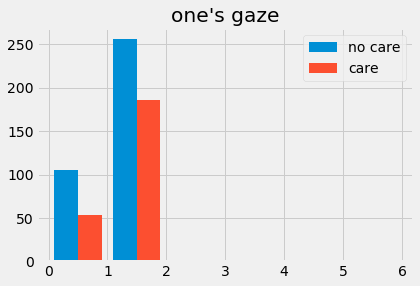

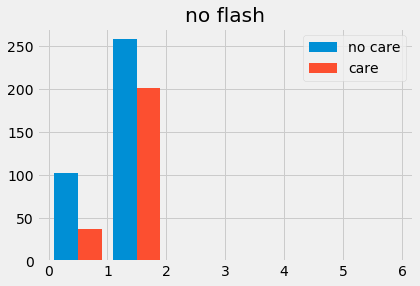

In [8]:
for column in df.drop(["image","care"],axis=1).columns:
    plt.hist([df.query('care == 0')[column], df.query('care == 1')[column]], stacked=False, label=["no care","care"], bins=range(0,7), alpha=1)
    plt.title(column)
    plt.legend()
    plt.show()

In [9]:
#散布図です。欲しいのは対角線に表示されている確率密度です。
# g = sns.pairplot(df.drop("image",axis=1),hue="care")
# g.fig.set_figheight(20)
# g.fig.set_figwidth(20)

In [10]:
image_size=160
X=[]

for image_path in tqdm(df["image"]):
    #画像ファイル取得
    img_file = glob.glob("./image/" + image_path)
    if not img_file:
        print(image_path)
        continue
    image = Image.open(img_file[0])
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    X.append(np.array(image))
    
del image

100%|██████████| 600/600 [00:08<00:00, 74.45it/s]


## 3, 小モデル作成

In [11]:
def create_model_vgg():
    base_model=VGG16(weights='imagenet',include_top=False,
                 input_tensor=Input(shape=(image_size,image_size,3)))
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.3)(x)
    prediction = Dense(1)(x)

    for layer in base_model.layers[:15]:
        layer.trainable=False
    
    return Model(inputs=base_model.input,outputs=prediction)

In [12]:
def create_model_vgg_binary():
    base_model=VGG16(weights='imagenet',include_top=False,
                 input_tensor=Input(shape=(image_size,image_size,3)))
    x = base_model.output
    
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.3)(x)
    prediction = Dense(2, activation='softmax')(x)
    
    for layer in base_model.layers[:15]:
        layer.trainable=False
    
    return Model(inputs=base_model.input,outputs=prediction)

In [13]:
class MyImageDataGenerator(ImageDataGenerator):
    def __init__(self, featurewise_center = False, samplewise_center = False, 
                 featurewise_std_normalization = False, samplewise_std_normalization = False, 
                 zca_whitening = False, zca_epsilon = 1e-06, rotation_range = 0.0, width_shift_range = 0.0, 
                 height_shift_range = 0.0, brightness_range = None, shear_range = 0.0, zoom_range = 0.0, 
                 channel_shift_range = 0.0, fill_mode = 'nearest', cval = 0.0, horizontal_flip = False, 
                 vertical_flip = False, rescale = None, preprocessing_function = None, data_format = None, validation_split = 0.0, 
                 brightness_ranges = 0.0):
        # 親クラスのコンストラクタ
        super().__init__(featurewise_center, samplewise_center, featurewise_std_normalization, samplewise_std_normalization, zca_whitening, zca_epsilon, rotation_range, width_shift_range, height_shift_range, brightness_range, shear_range, zoom_range, channel_shift_range, fill_mode, cval, horizontal_flip, vertical_flip, rescale, preprocessing_function, data_format, validation_split)
        # 拡張処理のパラメーター
        assert isinstance(brightness_ranges,float)
        self.brightness_ranges = brightness_ranges

    def flow(self, x, y=None, batch_size=32, shuffle=True, sample_weight=None,
             seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None):
        batches = super().flow(x=x, y=y, batch_size=batch_size, shuffle=shuffle, sample_weight=sample_weight,
                               seed=seed, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format, subset=subset)

        while True:
            batch_x, batch_y = next(batches)
            yield batch_x/255, batch_y

In [14]:
def get_datagen(column):

    if column=="front":
        param = {"zoom_range":0.2,
                "width_shift_range":0.1,
                "height_shift_range":0.1,
                "brightness_range":[0.4,1.0]
                }
        
    elif column=="close" or column=="focus":
        param = {"rotation_range":30,
                "width_shift_range":0.1,
                "height_shift_range":0.1,
                "horizontal_flip":True,
                "vertical_flip":True,
                "brightness_range":[0.4,1.0]}
        
    elif column=="background" or column=="plural":
        param = {"rotation_range":30,
                "horizontal_flip":True,
                "vertical_flip":True,
                "brightness_range":[0.4,1.0]}
        
    elif column=="position" or column=="one's gaze":
        param = {"brightness_range":[0.4,1.0]}
        
    elif column=="brightness" or column=="natural light" or column=="no flash":
        param = {"rotation_range":30,
                "zoom_range":0.2,
                "width_shift_range":0.1,
                "height_shift_range":0.1,
                "horizontal_flip":True,
                "vertical_flip":True}
        
    elif column=="natural light":
        param = {"rotation_range":30,
                "zoom_range":0.2,
                "width_shift_range":0.1,
                "height_shift_range":0.1,
                "horizontal_flip":True,
                "vertical_flip":True,}

    datagen = MyImageDataGenerator(**param)
    
    return datagen

In [15]:
def column_predict(X_train,X_valid,y_train,y_valid,column):
    
    model = create_model_vgg()
    reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                            patience=6, 
                                            verbose=1, 
                                            factor=0.6, 
                                            min_lr=0.00001)

    modelCheckpoint = ModelCheckpoint(filepath = "model/model_" + str(column) + ".h5",
                                          monitor='val_loss',
                                          verbose=0,
                                          save_best_only=True,
                                          period=1)
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')

    model.compile(loss='mean_squared_error', optimizer="rmsprop")
    
    
    datagen = get_datagen(column)
    datagen.fit(X_train)
    
    hist = model.fit_generator(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE),epochs=EPOCHS, verbose=2,
                               callbacks=[reduceLROnPlateau,modelCheckpoint,earlyStopping],
                               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                               validation_data = (X_valid,y_valid))
    
    model = load_model("model/model_" + str(column) + ".h5", compile=False)
    pred = model.predict(X_valid)
    MSE_pred = mean_squared_error(pred, y_valid)

    mean_pred = np.full(len(y_valid), y_train.mean())
    MSE_mean = mean_squared_error(mean_pred, y_valid)
    
    fig = plt.figure(figsize=(12, 16))
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(column, fontsize=20)
    
    ax1 = fig.add_subplot(211,
                          title="val_loss",
                          ylabel="val_loss",
                          xlabel="Epoch")
    ax1.plot(hist.history["val_loss"], alpha=0.8, color=color_list[5], linewidth = 2)
    ax1.legend(["Train", "Test"], loc="upper left")

    ax2 = fig.add_subplot(212,
                          title="pred(mse):" + str(MSE_pred)[:5] + "\n" +"baseline(mse):" + str(MSE_mean)[:5],
                          ylabel="Score",
                          xlabel="ID")
    ax2.plot(y_valid, label="True", alpha=0.8, color=color_list[2], linewidth = 2)
    ax2.plot(pred, label="Pred", alpha=0.8, color=color_list[3], linewidth = 2)
    ax2.plot(mean_pred, label="Mean", alpha=0.8, color=color_list[4], linewidth = 2)
    ax2.legend(loc="upper right")
    
    plt.show()
    
    return(pred)
    

In [16]:
def column_predict_binary(X_train,X_valid,y_train,y_valid,column):
    
    model = create_model_vgg_binary()
    reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                            patience=6, 
                                            verbose=1, 
                                            factor=0.6, 
                                            min_lr=0.00001)

    modelCheckpoint = ModelCheckpoint(filepath = "model/model_" + str(column) + ".h5",
                                          monitor='val_loss',
                                          verbose=0,
                                          save_best_only=True,
                                          period=1)
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')
    
    model.compile(loss='binary_crossentropy', optimizer="rmsprop")
    
    datagen = get_datagen(column)
    datagen.fit(X_train)
    
    y_train_c = to_categorical(y_train)
    y_valid_c = to_categorical(y_valid)
    
    hist = model.fit_generator(datagen.flow(X_train, y_train_c, batch_size=BATCH_SIZE),
                             epochs=EPOCHS, verbose=2,
                             callbacks=[reduceLROnPlateau,modelCheckpoint,earlyStopping],
                             steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                             validation_data = (X_valid,y_valid_c))
    
    model = load_model("model/model_" + str(column) + ".h5", compile=False)
    
    pred = model.predict(X_valid)
    pred = argmax(pred, axis=1)
    print(pred)
    ACC_pred = accuracy_score(pred, y_valid)

    mean_pred = np.full(len(y_valid), np.rint(y_train.mean()))
    ACC_mean = accuracy_score(mean_pred, y_valid)
    
    fig = plt.figure(figsize=(12, 16))
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(column, fontsize=20)
    
    ax1 = fig.add_subplot(211,
                          title="val_loss",
                          ylabel="val_loss",
                          xlabel="Epoch")
    ax1.plot(hist.history["val_loss"], alpha=0.8, color=color_list[5], linewidth = 2)
    ax1.legend(["Train", "Test"], loc="upper left")

    ax2 = fig.add_subplot(212,
                          title="pred(acc):" + str(ACC_pred)[:5] + "\n" +"baseline(acc):" + str(ACC_mean)[:5],
                          ylabel="Score",
                          xlabel="ID")
    ax2.plot(y_valid, label="True", alpha=0.8, color=color_list[2], linewidth = 2)
    ax2.plot(pred, label="Pred", alpha=0.8, color=color_list[3], linewidth = 2)
    ax2.plot(mean_pred, label="Mean", alpha=0.8, color=color_list[4], linewidth = 2)
    ax2.legend(loc="upper right")
    
    plt.show()
    
    return(pred)
    

In [17]:
SEED = 0
X = np.array(X)
Y = np.array(df[["front","close","background","focus","position","brightness","plural","natural light","one's gaze","no flash","care"]])

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2, random_state=SEED)

y_train,care_train = np.hsplit(y_train, [len(y_train[0])-1])
y_valid,care_valid = np.hsplit(y_valid, [len(y_valid[0])-1])

In [18]:
#X_train = X_train.astype("float32") / 255
X_valid = X_valid.astype("float32") / 255

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 10s - loss: 397.1041 - val_loss: 6332.5061
Epoch 2/100
7/7 - 4s - loss: 1.7333 - val_loss: 1256.5843
Epoch 3/100
7/7 - 2s - loss: 1.6702 - val_loss: 586.2810
Epoch 4/100
7/7 - 3s - loss: 2.3297 - val_loss: 578.2966
Epoch 5/100
7/7 - 3s - loss: 1.5235 - val_loss: 468.4238
Epoch 6/100
7/7 - 3s - loss: 2.3386 - val_loss: 301.2232
Epoch 7/100
7/7 - 3s - loss: 2.0890 - val_loss: 336.7873
Epoch 8/100
7/7 - 3s - loss: 2.1634 - val_loss: 87.7204
Epoch 9/100
7/7 - 3s - loss: 1.8958 - val_loss: 154.0316
Epoch 10/100
7/7 - 3s - loss: 2.7084 - val_loss: 81.2626
Epoch 11/100
7/7 - 2s - loss: 2.0373 - val_loss: 81.9927
Epoch 12/100
7/7 - 3s - loss: 1.8485 - val_loss: 10.4665
Epoch 13/100
7/7 - 3s - loss: 2.6364 - val_loss: 9.2664
Epoch 14/100
7/7 - 2s - loss: 2.2768 - val_loss: 707.2106
Epoch 15/100
7/7 - 3s - loss: 2.5832 - val_loss: 37.81

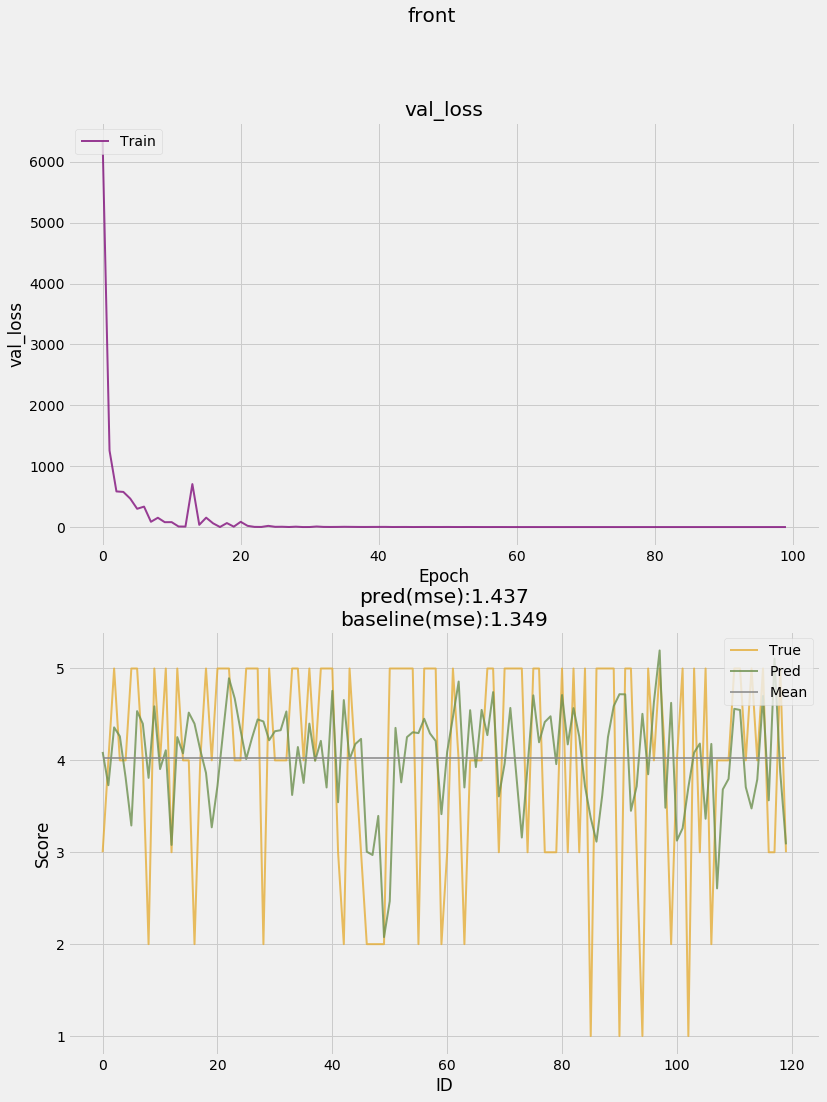

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 5s - loss: 308.6875 - val_loss: 192.8228
Epoch 2/100
7/7 - 3s - loss: 1.6678 - val_loss: 122.4338
Epoch 3/100
7/7 - 3s - loss: 2.1329 - val_loss: 16.7131
Epoch 4/100
7/7 - 3s - loss: 1.9493 - val_loss: 36.2297
Epoch 5/100
7/7 - 3s - loss: 2.2706 - val_loss: 10.1970
Epoch 6/100
7/7 - 3s - loss: 2.8062 - val_loss: 45.4034
Epoch 7/100
7/7 - 3s - loss: 1.4049 - val_loss: 13.5448
Epoch 8/100
7/7 - 3s - loss: 2.0946 - val_loss: 45.5012
Epoch 9/100
7/7 - 3s - loss: 1.4711 - val_loss: 2.0726
Epoch 10/100
7/7 - 3s - loss: 2.0333 - val_loss: 404.2094
Epoch 11/100
7/7 - 3s - loss: 1.5359 - val_loss: 9.4408
Epoch 12/100
7/7 - 3s - loss: 1.1917 - val_loss: 2.1122
Epoch 13/100
7/7 - 3s - loss: 1.4215 - val_loss: 5.4575
Epoch 14/100
7/7 - 3s - loss: 1.2069 - val_loss: 2.3224
Epoch 15/100

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
7/7 - 3s - loss: 1.1321 - val_loss: 2.2498
Epoch 

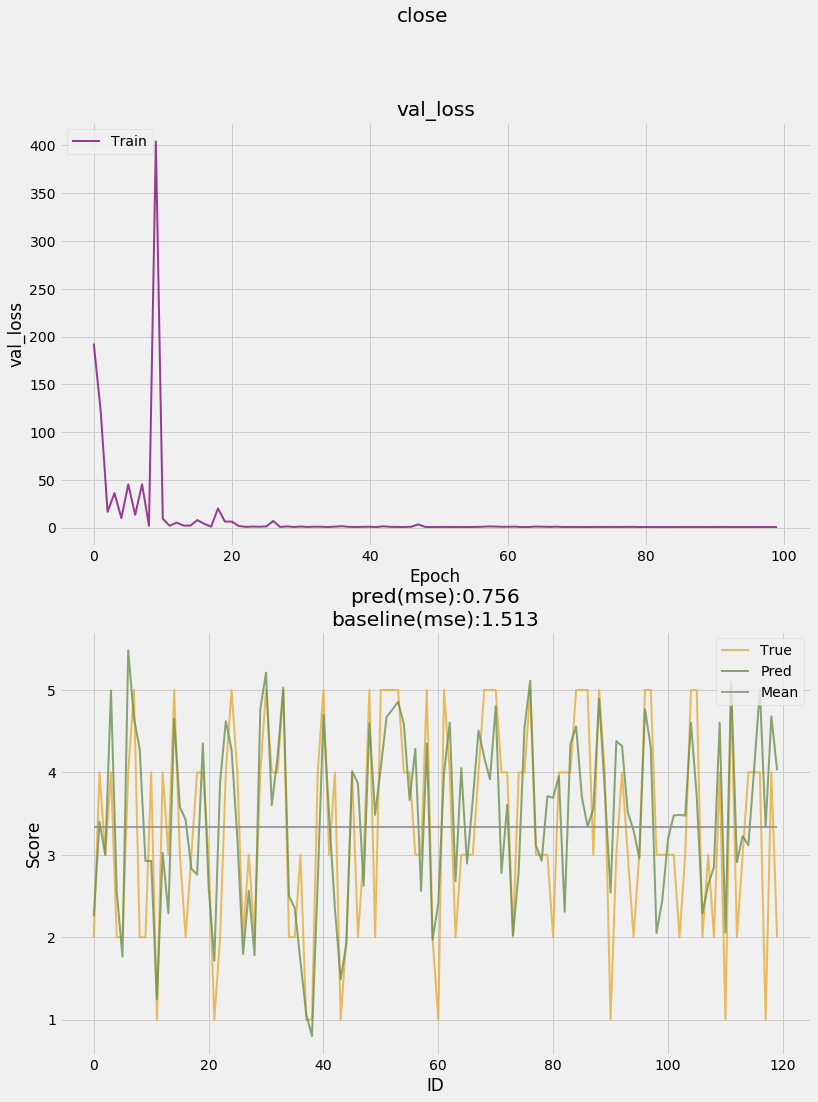

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 5s - loss: 105.3228 - val_loss: 3773.2046
Epoch 2/100
7/7 - 3s - loss: 1.8549 - val_loss: 5.1239
Epoch 3/100
7/7 - 3s - loss: 1.7845 - val_loss: 59.7273
Epoch 4/100
7/7 - 3s - loss: 1.6075 - val_loss: 30.2572
Epoch 5/100
7/7 - 3s - loss: 1.8132 - val_loss: 50.3855
Epoch 6/100
7/7 - 3s - loss: 1.8213 - val_loss: 23.1915
Epoch 7/100
7/7 - 3s - loss: 1.6381 - val_loss: 2.5233
Epoch 8/100
7/7 - 2s - loss: 1.4638 - val_loss: 5.9009
Epoch 9/100
7/7 - 3s - loss: 1.4163 - val_loss: 8.3267
Epoch 10/100
7/7 - 3s - loss: 1.6182 - val_loss: 2.5487
Epoch 11/100
7/7 - 3s - loss: 1.8321 - val_loss: 3.0352
Epoch 12/100
7/7 - 3s - loss: 1.2319 - val_loss: 1.6351
Epoch 13/100
7/7 - 3s - loss: 1.1870 - val_loss: 1.8811
Epoch 14/100
7/7 - 3s - loss: 1.6185 - val_loss: 8.0351
Epoch 15/100
7/7 - 3s - loss: 1.5988 - val_loss: 8.1719
Epoch 16/100
7/7 - 3s - loss: 1.5772 - val_loss: 551.1139
Epoch 17/100
7/7 - 3s - loss: 3.58

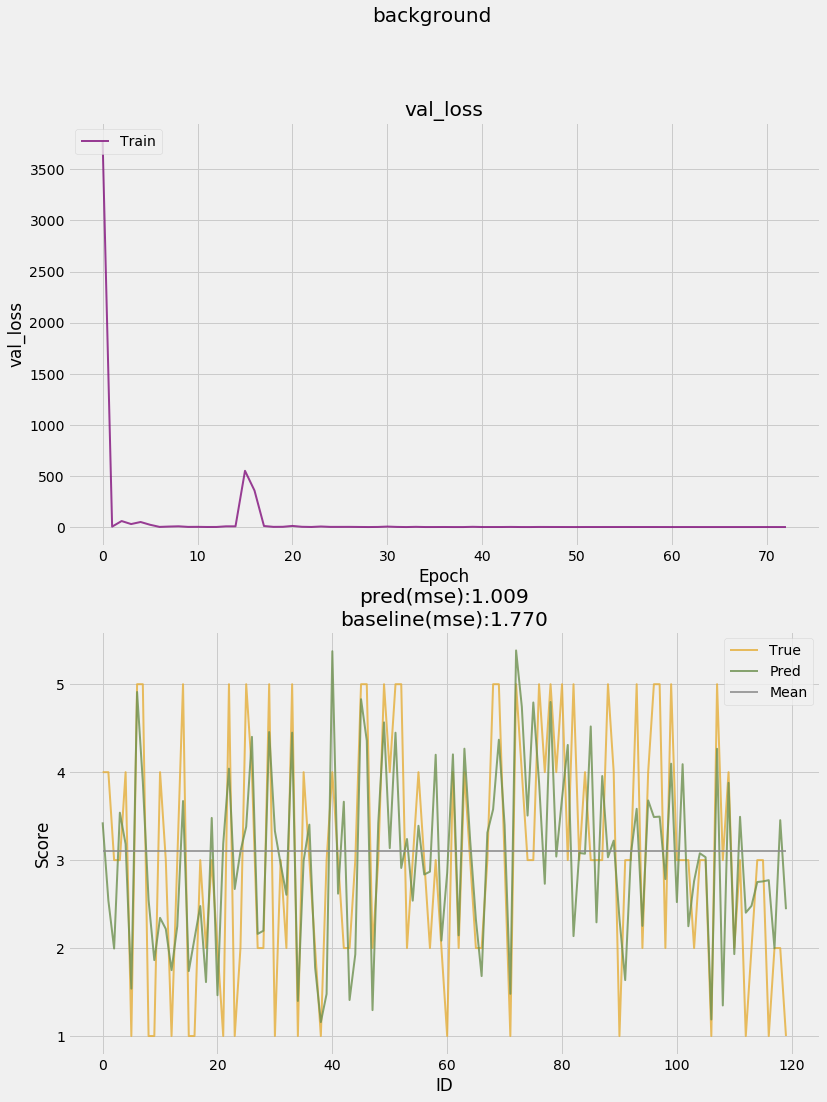

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 5s - loss: 353.8645 - val_loss: 174.3175
Epoch 2/100
7/7 - 3s - loss: 2.6478 - val_loss: 458.0042
Epoch 3/100
7/7 - 3s - loss: 1.5040 - val_loss: 86.4483
Epoch 4/100
7/7 - 3s - loss: 2.3654 - val_loss: 183.1470
Epoch 5/100
7/7 - 3s - loss: 1.7930 - val_loss: 57.5591
Epoch 6/100
7/7 - 3s - loss: 2.4083 - val_loss: 82.9738
Epoch 7/100
7/7 - 3s - loss: 2.1713 - val_loss: 75.2086
Epoch 8/100
7/7 - 3s - loss: 1.8726 - val_loss: 16.1960
Epoch 9/100
7/7 - 3s - loss: 2.1950 - val_loss: 11.4615
Epoch 10/100
7/7 - 3s - loss: 2.2401 - val_loss: 103.9874
Epoch 11/100
7/7 - 3s - loss: 1.9903 - val_loss: 12.0179
Epoch 12/100
7/7 - 3s - loss: 2.6388 - val_loss: 8206.8423
Epoch 13/100
7/7 - 3s - loss: 1.7672 - val_loss: 140.8236
Epoch 14/100
7/7 - 3s - loss: 1.8725 - val_loss: 18.1512
Epoch 15/100

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
7/7 - 3s - loss: 1.6041 - val_loss: 64.4

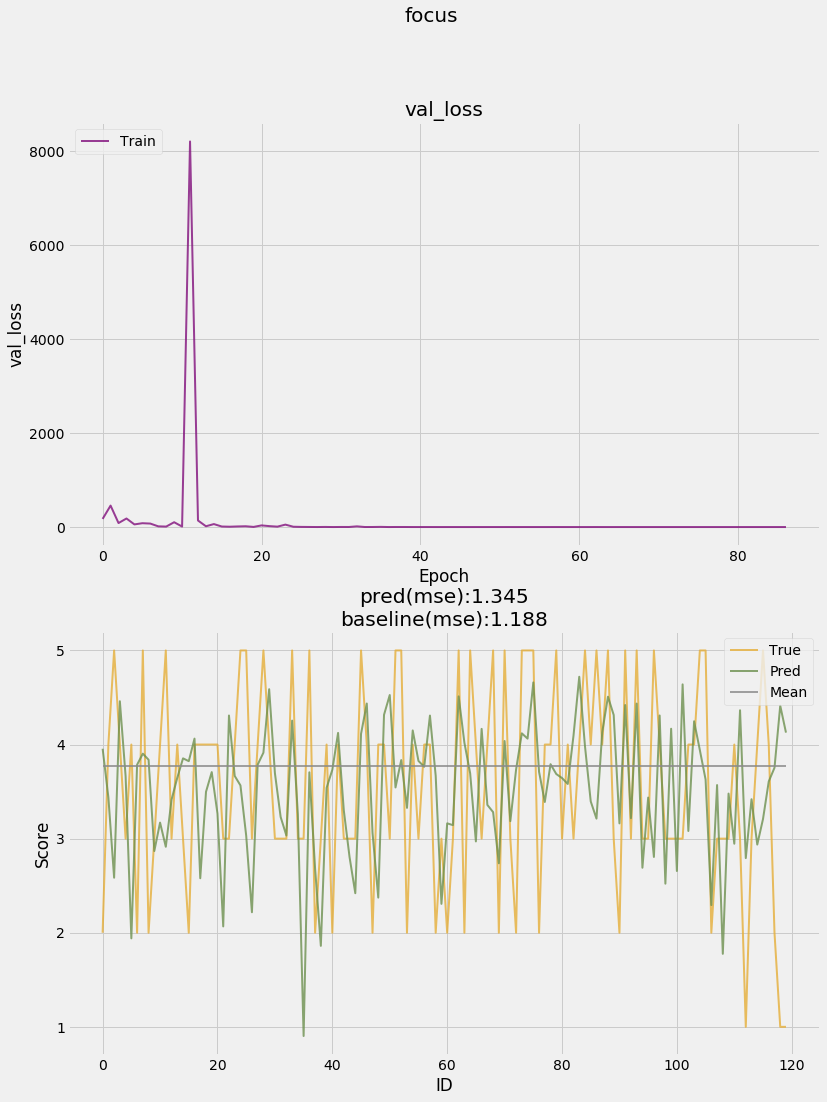

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 4s - loss: 195.7833 - val_loss: 5796.9485
Epoch 2/100
7/7 - 2s - loss: 1.7695 - val_loss: 995.1278
Epoch 3/100
7/7 - 2s - loss: 0.9967 - val_loss: 465.2572
Epoch 4/100
7/7 - 2s - loss: 0.8990 - val_loss: 206.2277
Epoch 5/100
7/7 - 2s - loss: 1.3881 - val_loss: 125.8211
Epoch 6/100
7/7 - 2s - loss: 0.9165 - val_loss: 58.7814
Epoch 7/100
7/7 - 2s - loss: 1.3958 - val_loss: 155.5969
Epoch 8/100
7/7 - 2s - loss: 1.2892 - val_loss: 22.7856
Epoch 9/100
7/7 - 2s - loss: 1.1114 - val_loss: 22.6536
Epoch 10/100
7/7 - 2s - loss: 1.3440 - val_loss: 7.8556
Epoch 11/100
7/7 - 2s - loss: 1.2272 - val_loss: 62.0994
Epoch 12/100
7/7 - 2s - loss: 1.2004 - val_loss: 41.1558
Epoch 13/100
7/7 - 2s - loss: 1.1023 - val_loss: 14.2626
Epoch 14/100
7/7 - 2s - loss: 1.3870 - val_loss: 1.5938
Epoch 15/100
7/7 - 2s - loss: 1.0552 - val_loss: 1.9073
Epoch 16/100
7/7 - 2s - loss: 1.3283 - val_loss: 2.1088
Epoch 17/100
7/7 - 2s - 

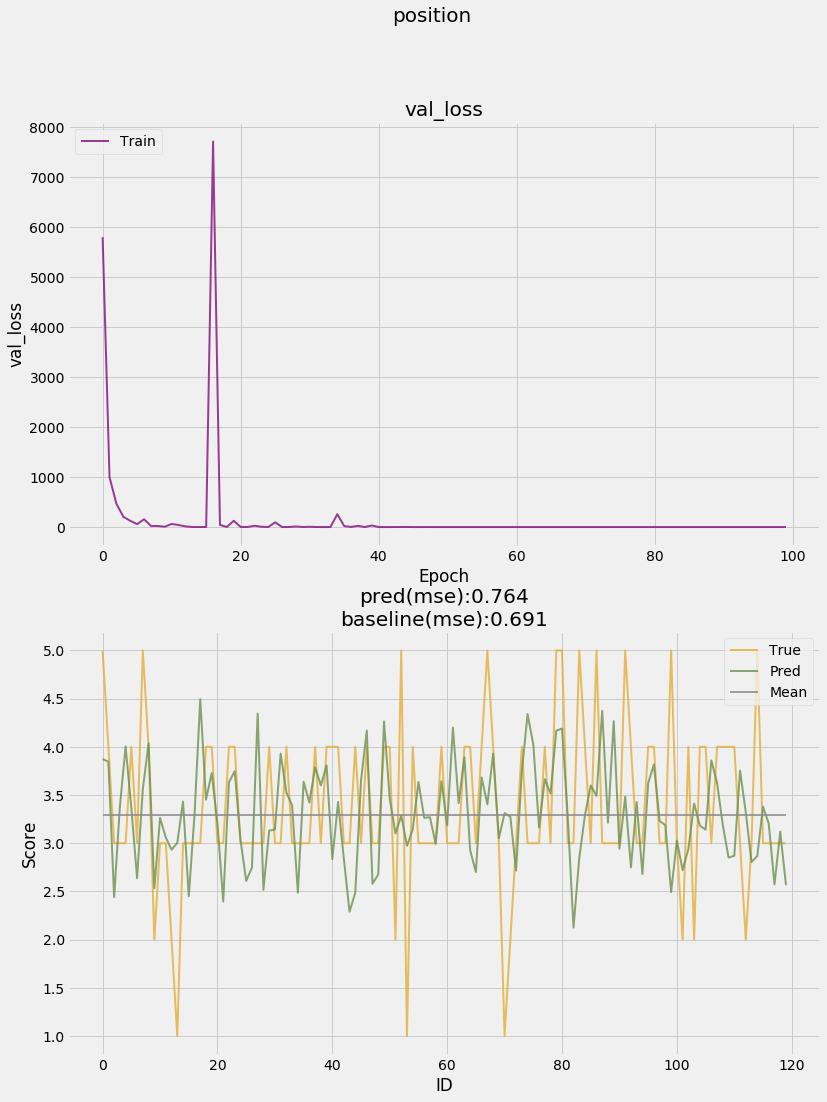

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 5s - loss: 346.5887 - val_loss: 340.8048
Epoch 2/100
7/7 - 2s - loss: 0.9175 - val_loss: 30.8950
Epoch 3/100
7/7 - 3s - loss: 0.9519 - val_loss: 27.0556
Epoch 4/100
7/7 - 3s - loss: 0.8544 - val_loss: 12.9518
Epoch 5/100
7/7 - 3s - loss: 0.8331 - val_loss: 11.9501
Epoch 6/100
7/7 - 3s - loss: 1.0011 - val_loss: 10.0531
Epoch 7/100
7/7 - 2s - loss: 0.9780 - val_loss: 5.2430
Epoch 8/100
7/7 - 2s - loss: 0.9556 - val_loss: 3.8808
Epoch 9/100
7/7 - 2s - loss: 0.7151 - val_loss: 10.6345
Epoch 10/100
7/7 - 2s - loss: 1.4059 - val_loss: 15.0397
Epoch 11/100
7/7 - 3s - loss: 0.9451 - val_loss: 1.1901
Epoch 12/100
7/7 - 2s - loss: 1.1401 - val_loss: 8.2631
Epoch 13/100
7/7 - 2s - loss: 1.1221 - val_loss: 3.0216
Epoch 14/100
7/7 - 2s - loss: 0.9423 - val_loss: 6.4084
Epoch 15/100
7/7 - 2s - loss: 1.0135 - val_loss: 1.7739
Epoch 16/100
7/7 - 2s - loss: 1.1272 - val_loss: 5.5366
Epoch 17/100
7/7 - 3s - loss: 1.99

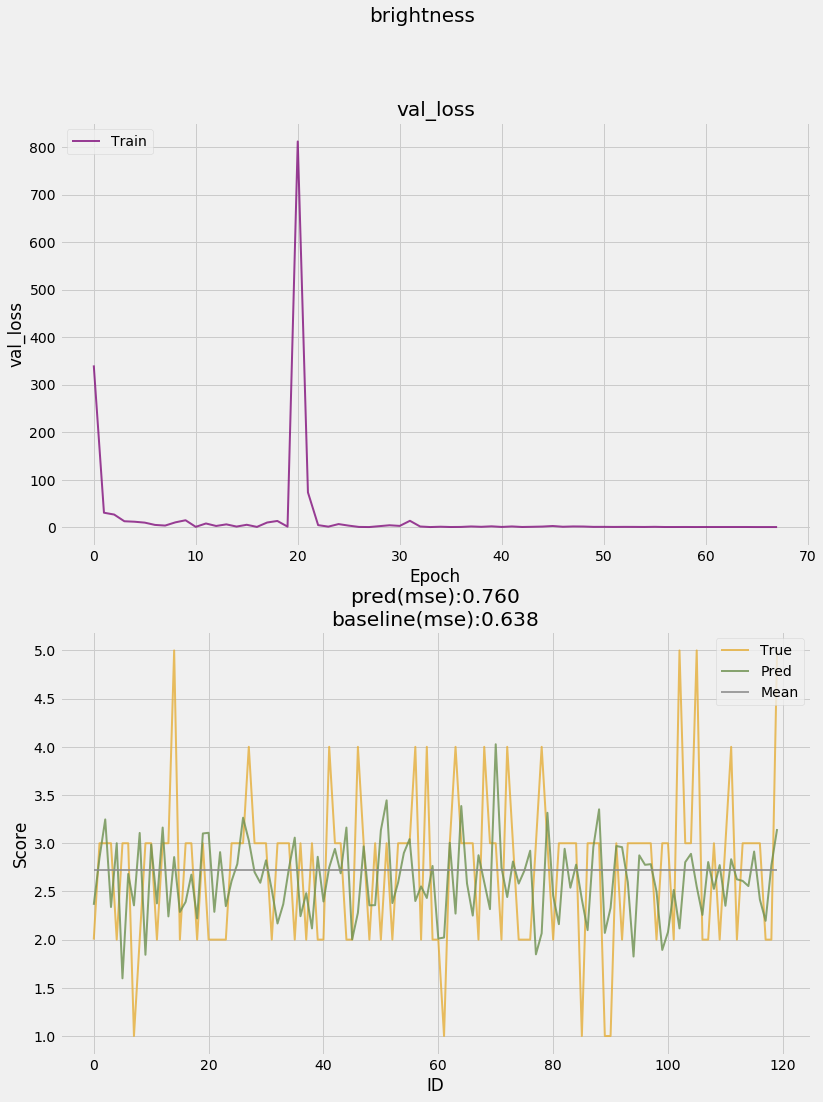

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 5s - loss: 0.4056 - val_loss: 15.2093
Epoch 2/100
7/7 - 2s - loss: 0.1728 - val_loss: 15.2093
Epoch 3/100
7/7 - 3s - loss: 0.2765 - val_loss: 15.2039
Epoch 4/100
7/7 - 3s - loss: 0.1383 - val_loss: 14.3350
Epoch 5/100
7/7 - 3s - loss: 0.3065 - val_loss: 12.7833
Epoch 6/100
7/7 - 3s - loss: 0.2719 - val_loss: 9.7792
Epoch 7/100
7/7 - 3s - loss: 0.1037 - val_loss: 6.3093
Epoch 8/100
7/7 - 3s - loss: 0.2719 - val_loss: 4.1298
Epoch 9/100
7/7 - 3s - loss: 0.2054 - val_loss: 2.4490
Epoch 10/100
7/7 - 3s - loss: 0.2719 - val_loss: 1.2531
Epoch 11/100
7/7 - 3s - loss: 0.2719 - val_loss: 0.6758
Epoch 12/100
7/7 - 3s - loss: 0.2074 - val_loss: 0.3822
Epoch 13/100
7/7 - 3s - loss: 0.1728 - val_loss: 0.2453
Epoch 14/100
7/7 - 3s - loss: 0.2419 - val_loss: 0.1731
Epoch 15/100
7/7 - 3s - loss: 0.2028 - val_loss: 0.1393
Epoch 16/100
7/7 - 3s - loss: 0.2373 - val_loss: 0.1284
Epoch 17/100
7/7 - 3s - loss: 0.2396 - v

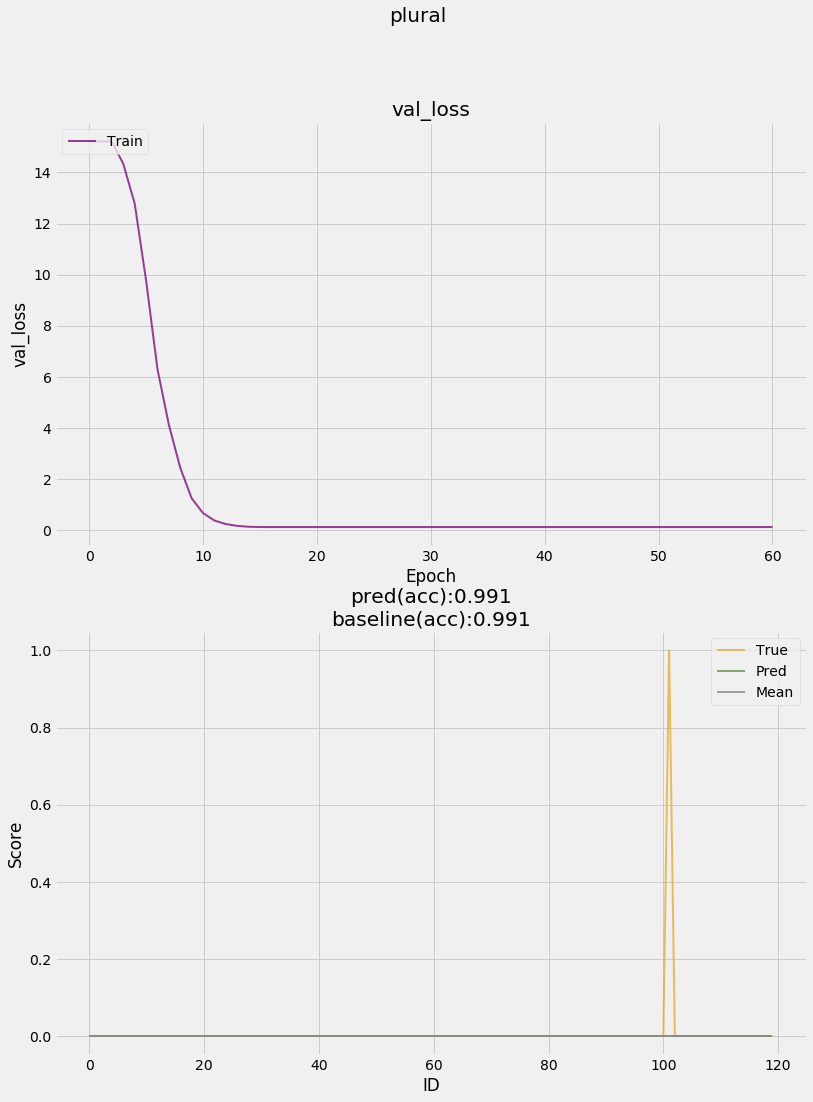

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 5s - loss: 3.2574 - val_loss: 8.6910
Epoch 2/100
7/7 - 2s - loss: 0.8689 - val_loss: 5.7760
Epoch 3/100
7/7 - 3s - loss: 0.6984 - val_loss: 3.8612
Epoch 4/100
7/7 - 3s - loss: 0.6844 - val_loss: 6.4792
Epoch 5/100
7/7 - 2s - loss: 0.6406 - val_loss: 7.7453
Epoch 6/100
7/7 - 4s - loss: 0.7253 - val_loss: 6.2450
Epoch 7/100
7/7 - 3s - loss: 0.6405 - val_loss: 6.2226
Epoch 8/100
7/7 - 2s - loss: 0.6285 - val_loss: 7.6754
Epoch 9/100
7/7 - 3s - loss: 0.6344 - val_loss: 1.6751
Epoch 10/100
7/7 - 2s - loss: 0.6084 - val_loss: 3.3635
Epoch 11/100
7/7 - 2s - loss: 0.6662 - val_loss: 8.0480
Epoch 12/100
7/7 - 2s - loss: 0.8515 - val_loss: 7.7227
Epoch 13/100
7/7 - 2s - loss: 0.6586 - val_loss: 5.9674
Epoch 14/100
7/7 - 2s - loss: 0.5890 - val_loss: 3.0791
Epoch 15/100

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
7/7 - 2s - loss: 0.6737 - val_loss: 6.5889
Epoch 16/100
7/7 - 2

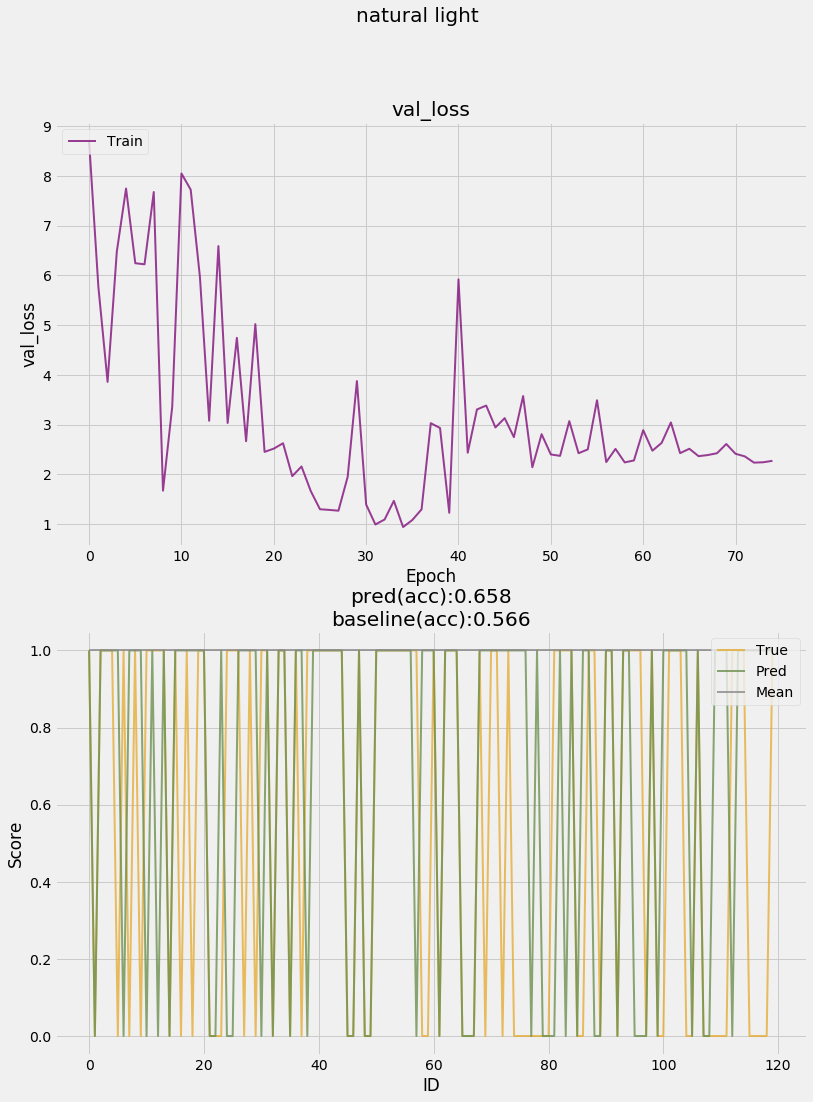

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 4s - loss: 3.8820 - val_loss: 11.5028
Epoch 2/100
7/7 - 2s - loss: 1.3511 - val_loss: 3.2283
Epoch 3/100
7/7 - 2s - loss: 0.6014 - val_loss: 3.4304
Epoch 4/100
7/7 - 2s - loss: 0.5823 - val_loss: 1.7319
Epoch 5/100
7/7 - 2s - loss: 0.5498 - val_loss: 9.3796
Epoch 6/100
7/7 - 2s - loss: 0.6434 - val_loss: 2.7846
Epoch 7/100
7/7 - 2s - loss: 0.4690 - val_loss: 2.1531
Epoch 8/100
7/7 - 2s - loss: 0.4610 - val_loss: 1.7322
Epoch 9/100
7/7 - 2s - loss: 0.4025 - val_loss: 3.5299
Epoch 10/100

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
7/7 - 2s - loss: 0.3745 - val_loss: 2.6304
Epoch 11/100
7/7 - 2s - loss: 0.2724 - val_loss: 1.3127
Epoch 12/100
7/7 - 2s - loss: 0.1524 - val_loss: 6.6128
Epoch 13/100
7/7 - 2s - loss: 0.1443 - val_loss: 2.7995
Epoch 14/100
7/7 - 2s - loss: 0.0930 - val_loss: 3.4007
Epoch 15/100
7/7 - 2s - loss: 0.0849 - val_loss: 3.3851
Epoch 16/100
7/7 - 

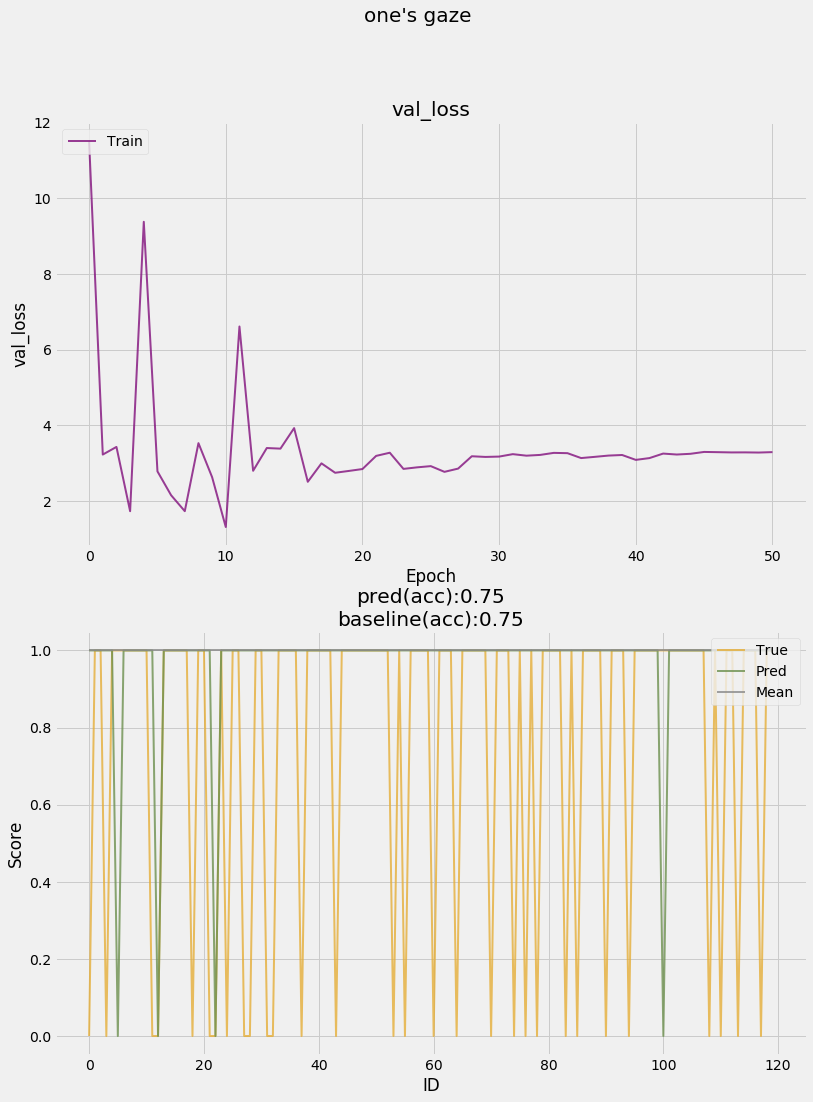

  ...
    to  
  ['...']
Train for 7 steps, validate on 120 samples
Epoch 1/100
7/7 - 5s - loss: 3.5381 - val_loss: 11.8862
Epoch 2/100
7/7 - 2s - loss: 0.6629 - val_loss: 10.6127
Epoch 3/100
7/7 - 2s - loss: 0.5808 - val_loss: 10.1259
Epoch 4/100
7/7 - 3s - loss: 0.5610 - val_loss: 8.2028
Epoch 5/100
7/7 - 3s - loss: 0.5209 - val_loss: 0.9239
Epoch 6/100
7/7 - 2s - loss: 0.5827 - val_loss: 5.8582
Epoch 7/100
7/7 - 2s - loss: 0.6873 - val_loss: 2.4803
Epoch 8/100
7/7 - 2s - loss: 0.6167 - val_loss: 1.7784
Epoch 9/100
7/7 - 3s - loss: 0.5085 - val_loss: 3.3785
Epoch 10/100
7/7 - 2s - loss: 0.5395 - val_loss: 8.1936
Epoch 11/100

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
7/7 - 2s - loss: 0.4973 - val_loss: 3.7186
Epoch 12/100
7/7 - 2s - loss: 0.3977 - val_loss: 1.1717
Epoch 13/100
7/7 - 2s - loss: 0.4203 - val_loss: 1.4911
Epoch 14/100
7/7 - 2s - loss: 0.4216 - val_loss: 0.9734
Epoch 15/100
7/7 - 3s - loss: 0.4194 - val_loss: 0.8815
Epoch 16/100
7/7 

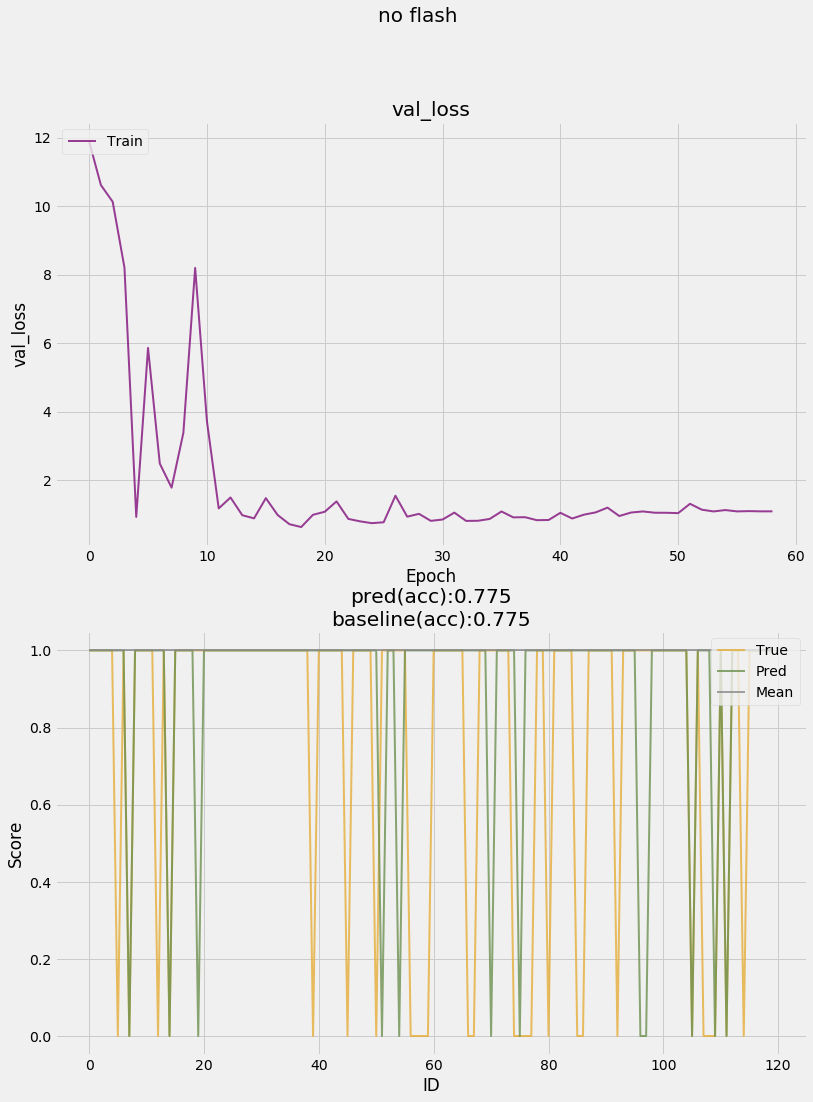

In [19]:
EPOCHS = 100
BATCH_SIZE = 64

pred_list = []
#for i,column in enumerate(["front","close","background","focus","cute","position","brightness","plural","natural light","one's gaze","no flash"]):
for i,column in enumerate(["front","close","background","focus","position","brightness","plural","natural light","one's gaze","no flash"]):
    print("============================================================")
    
    #特定のカラムに対する予想を飛ばす場合
#     if column in ["front","close","background","focus","cute","position","brightness","plural"]:
#         print("pass column:" + str(column))
#         continue
    
    #2値分類かそうでないかで分岐
    if len(set(y_train.T[i])) == 2:
        pred_list.append(column_predict_binary(X_train,X_valid,y_train.T[i],y_valid.T[i],column))
    else:
        pred_list.append(column_predict(X_train,X_valid,y_train.T[i],y_valid.T[i],column))
        
pickle.dump(pred_list,open("pred_list.sav","wb"))

## 4, 大モデル作成

In [20]:
X2 = df[["front","close","background","focus","position","brightness","plural","natural light","one's gaze","no flash"]]
Y2 = df["care"].values
pred_list = pickle.load(open("pred_list.sav","rb"))

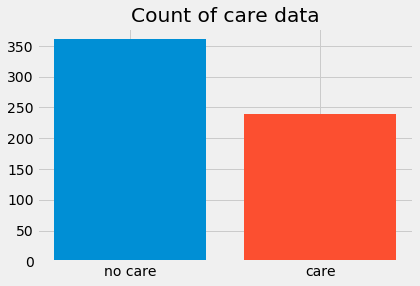

In [21]:
#偏りはsample_weightで調整する予定
plt.bar(0,df.groupby("care").size().values[0])
plt.bar(1,df.groupby("care").size().values[1])
plt.title("Count of care data")
plt.xticks([0,1], ["no care","care"])
plt.show()

In [22]:
#最適化される関数
def objective(x,y,trial):
    params={
        "num_leaves":trial.suggest_int("num_leaves",30,300),
        "learning_rate":trial.suggest_uniform("learning_rate",0.1,1.0),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.1,1.0),
        "max_depth":trial.suggest_int("max_depth",4,20),
        "objective":trial.suggest_categorical("objective",["binary"]),
        "random_state":trial.suggest_int("random_state",0,0)
    }
    
    score = 0
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
    for train_index,test_index in kf.split(x,y):
        X_train = x.iloc[train_index]
        X_test = x.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        score += accuracy_score(y_test,pred)
    return score    

In [23]:
def last_predict_lgb(X,Y,image):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = SEED,test_size = 0.2)

    evals_result = {}
    study = optuna.create_study(direction="maximize",sampler=optuna.samplers.RandomSampler(seed=0))
    study.optimize(partial(objective,X_train,y_train),n_trials=200)
    model = lgb.LGBMClassifier(**study.best_params)
    model.fit(X_train, y_train, callbacks=[lgb.record_evaluation(evals_result)])
    pickle.dump(model,open("model/model_lgb.sav","wb"))
    
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print("acc:" + str(acc)[:4])
    print()
    print("confusion_matrix:")
    cm = ConfusionMatrix(pred, y_test)
    cm.print_matrix()
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test, label="Actual", alpha=0.8)
    plt.plot(pred, c="b", label="pred", alpha=0.8)
    plt.legend(loc="upper right")
    plt.show()
    
    Xcolumns = X.columns
    features = Xcolumns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    #importance
    plt.figure(figsize=(8,4))
    plt.title("importance")
    plt.barh(range(len(indices)),importances[indices],align="center")
    plt.yticks(range(len(indices)),features[indices])
    plt.show()
    
    #shap
    explainer = shap.TreeExplainer(model,X)    
    for i in range(3):
        print(str(i))
        plt.imshow(image[i])
        plt.show()
        
        shap_values = explainer.shap_values(X.loc[[i]])
        shap.force_plot(explainer.expected_value, 
                    shap_values, 
                    X.loc[[i]], 
                    matplotlib=True,
                    )

In [24]:
def last_predict_dt(X,Y,image):
    from IPython.display import Image
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = SEED,test_size = 0.2)

    model = DecisionTreeClassifier(max_depth=3)
    model.fit(X_train, y_train)
    pickle.dump(model,open("model/model_dt.sav","wb"))
    
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print("acc:" + str(acc)[:4])
    print()
    print("confusion_matrix:")
    cm = ConfusionMatrix(pred, y_test)
    cm.print_matrix()
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test, label="True", alpha=0.8, color=color_list[2], linewidth = 2)
    plt.plot(pred, c="b", label="Pred", alpha=0.8, color=color_list[3], linewidth = 2)
    plt.legend(loc="upper right")
    plt.show()
    
    Xcolumns = X.columns
    features = Xcolumns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    #importance
    plt.figure(figsize=(8,4))
    plt.title("importance")
    plt.barh(range(len(indices)),importances[indices],align="center", color=color_list[4])
    plt.yticks(range(len(indices)),features[indices])
    plt.show()
    
    #shap
    explainer = shap.TreeExplainer(model)    
    for i in range(10):
        print("=" * 25)
        print("No." + str(i))
        
        print("no care") if Y[i]==0 else print("care")
        
        plt.imshow(image[i])
        plt.show()
        
        
        plot_polar(["front","close","background","focus","position","brightness","plural","natural light","one's gaze","no flash"], X.loc[i].values)
        
        
        shap_values = explainer.shap_values(X.loc[[i]])
        shap.force_plot(explainer.expected_value[1], 
                    shap_values[1], 
                    X.loc[[i]], 
                    matplotlib=True,
                    )
    
    #決定木モデルの構造を画像出力
    dot_data = StringIO()
    tree.export_graphviz(model, 
                        class_names=["not_care","care"],
                        feature_names=["front","close","background","focus","position","brightness","plural","natural light","one's gaze","no flash"],
                        filled=True,
                        rounded=True,
                        out_file=dot_data
                    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    #graph.write_pdf("./graph1.pdf")
    #Image(graph.create_png())
    #graph

acc:0.56

confusion_matrix:
Predict  0        1        
Actual
0        59       35       

1        17       9        




Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


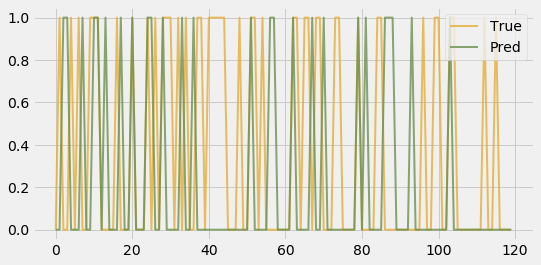

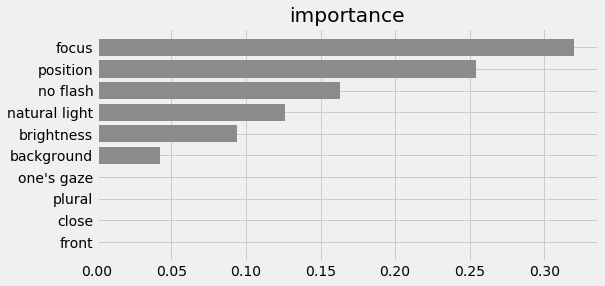

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


No.0
no care


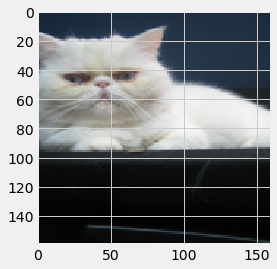

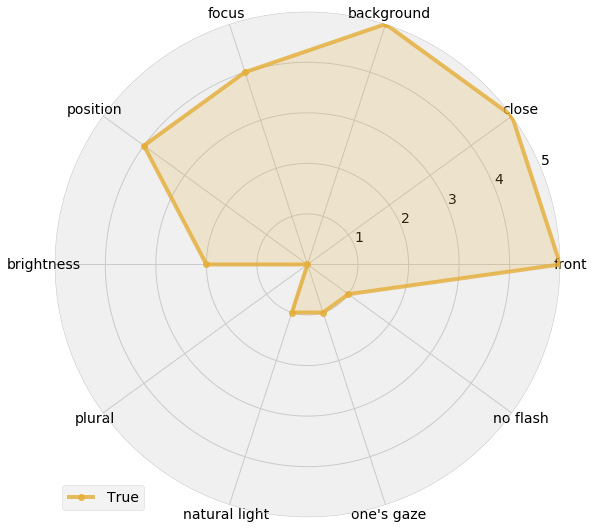

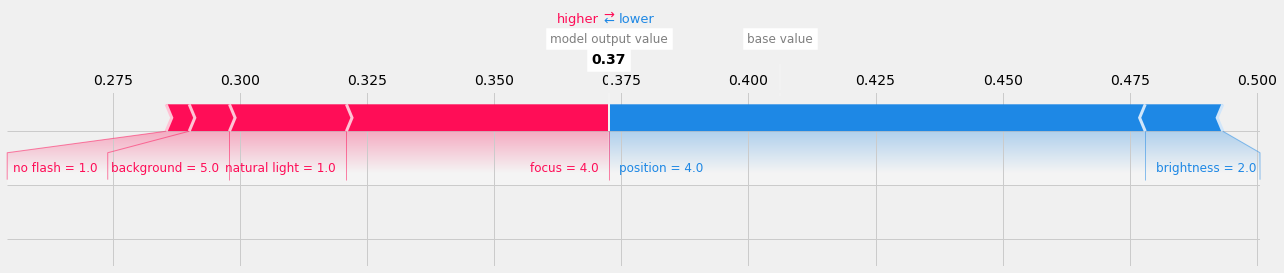

No.1
no care


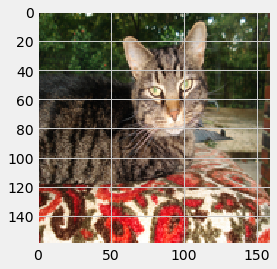

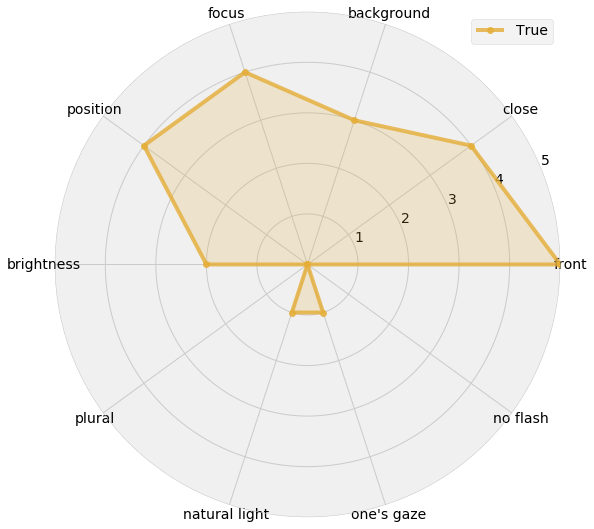

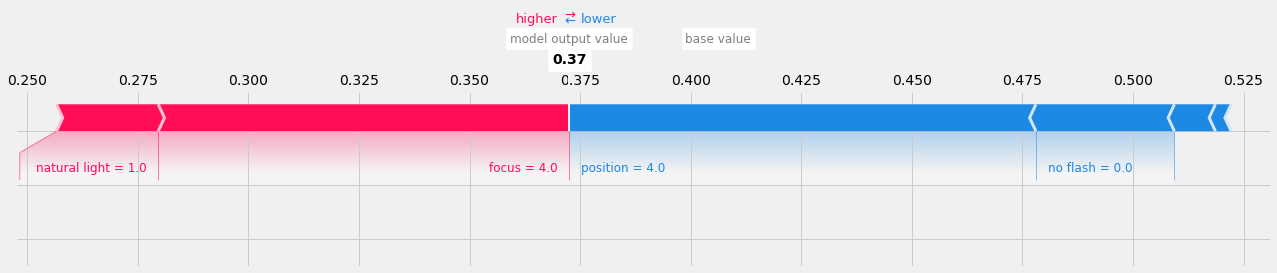

No.2
care


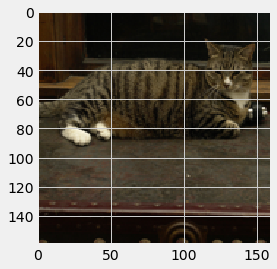

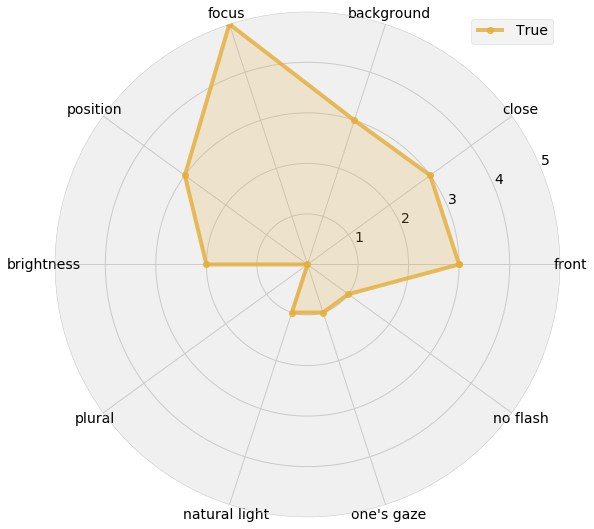

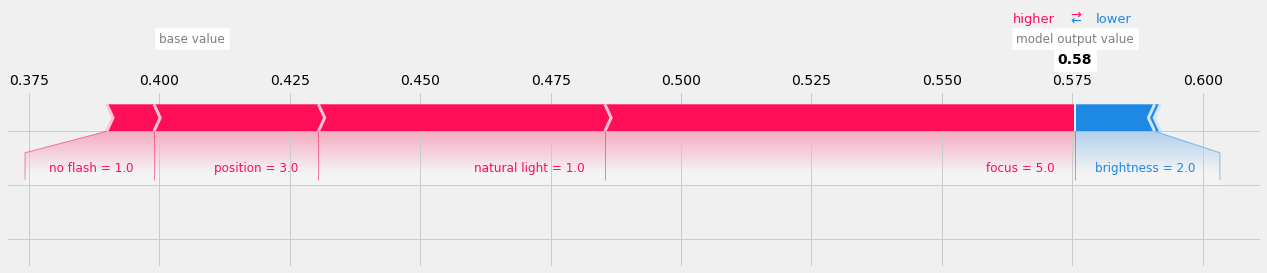

No.3
care


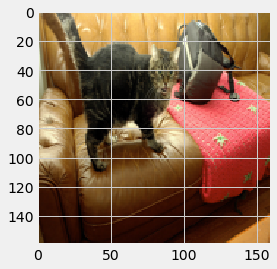

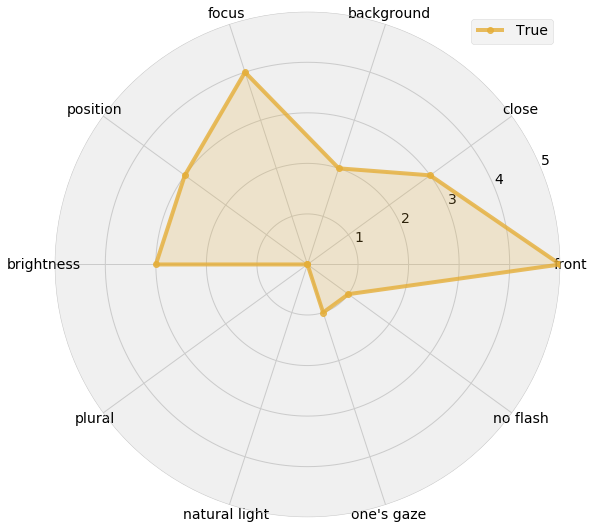

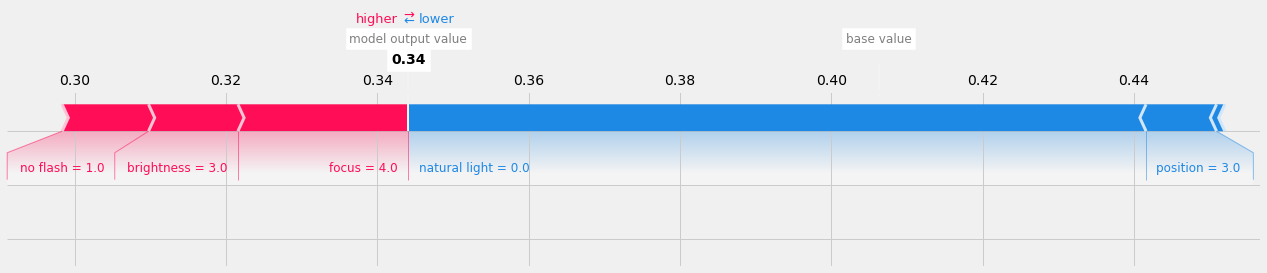

No.4
no care


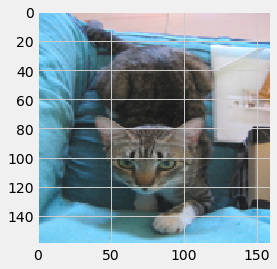

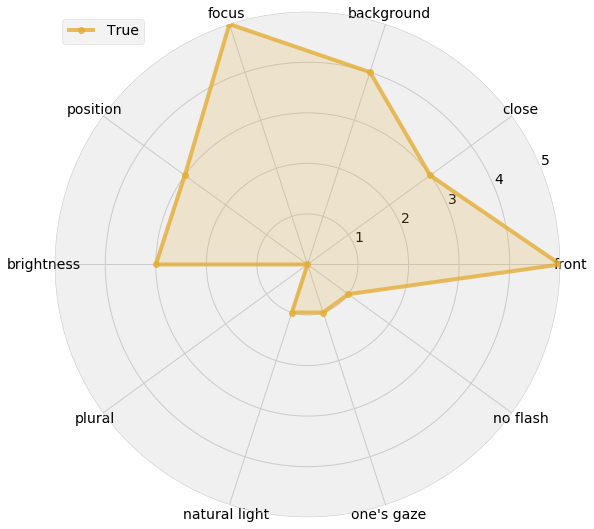

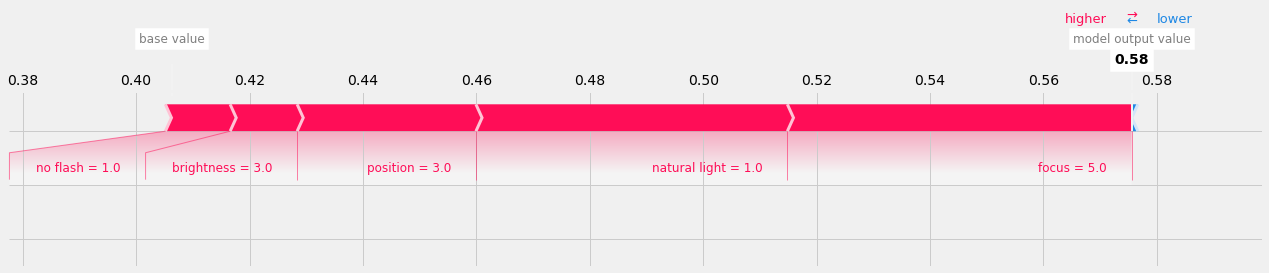

No.5
no care


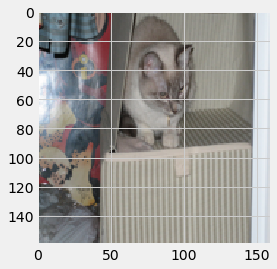

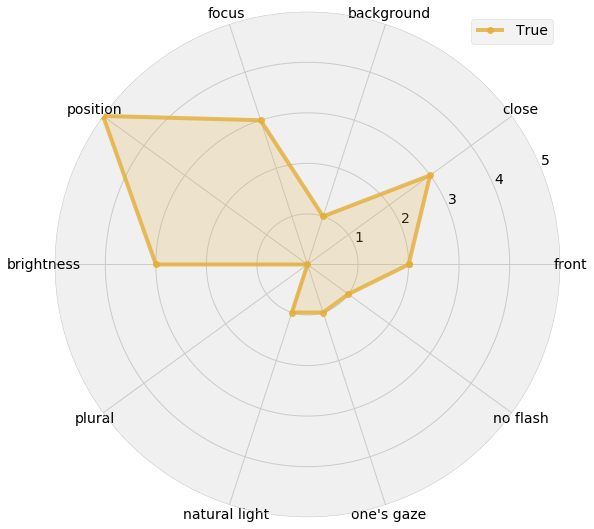

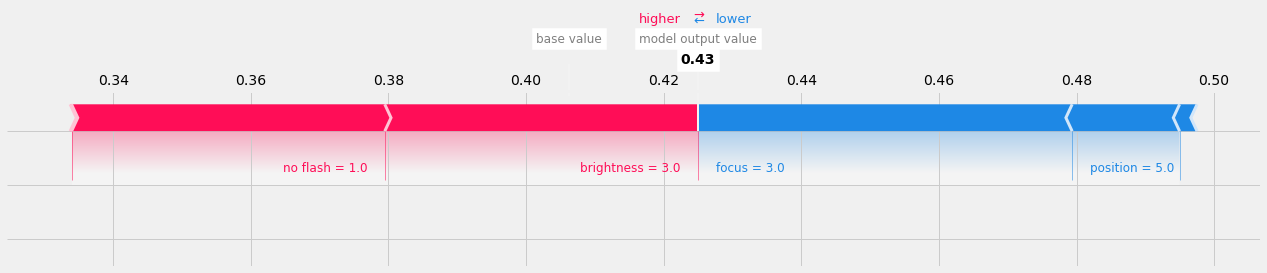

No.6
care


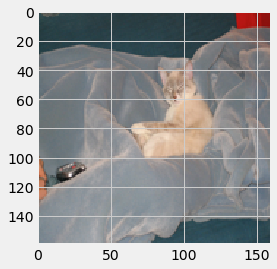

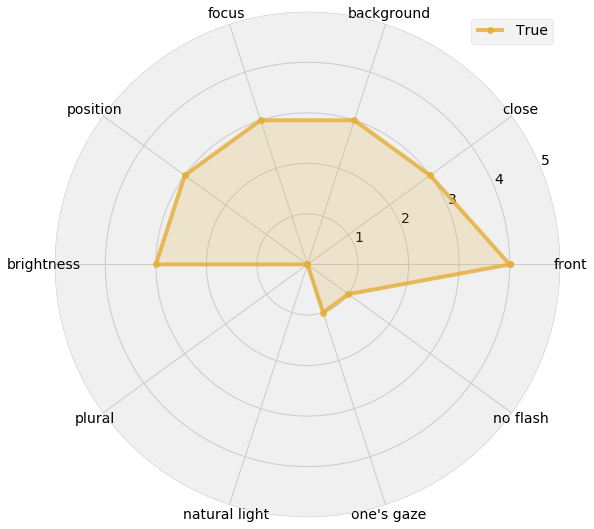

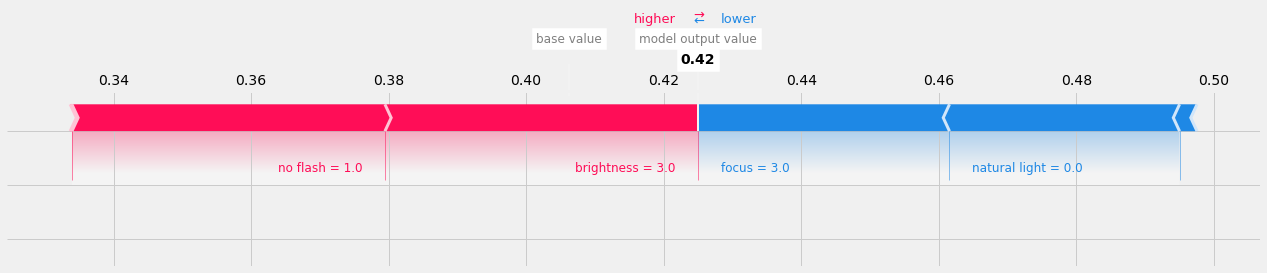

No.7
no care


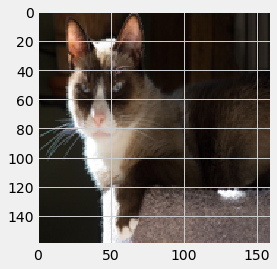

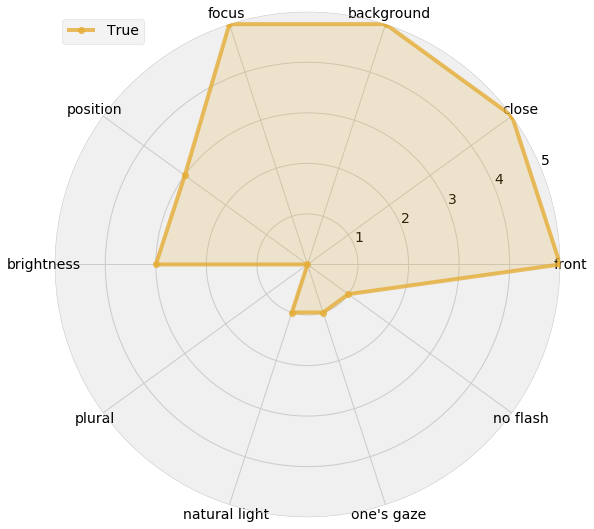

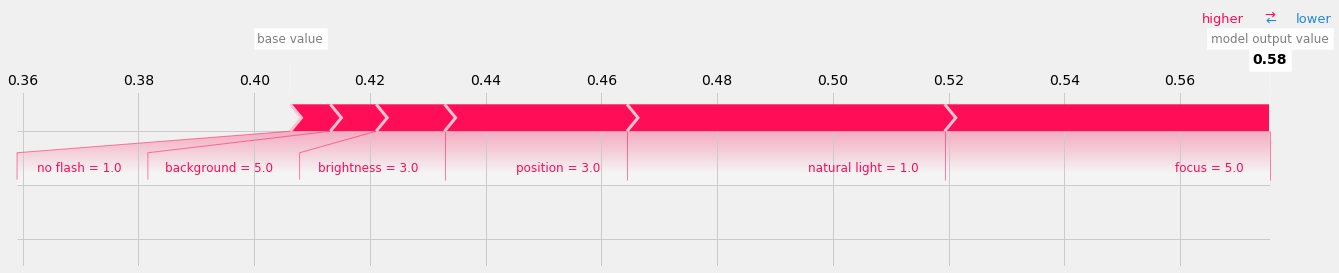

No.8
no care


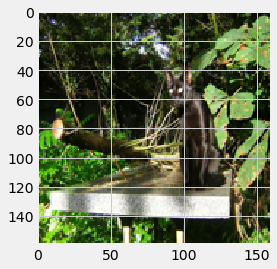

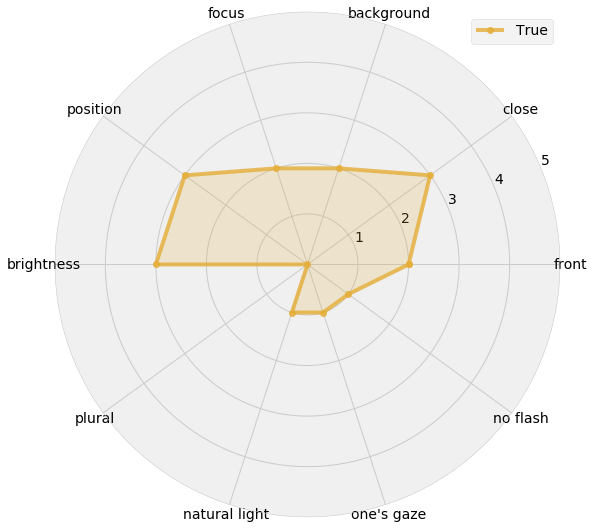

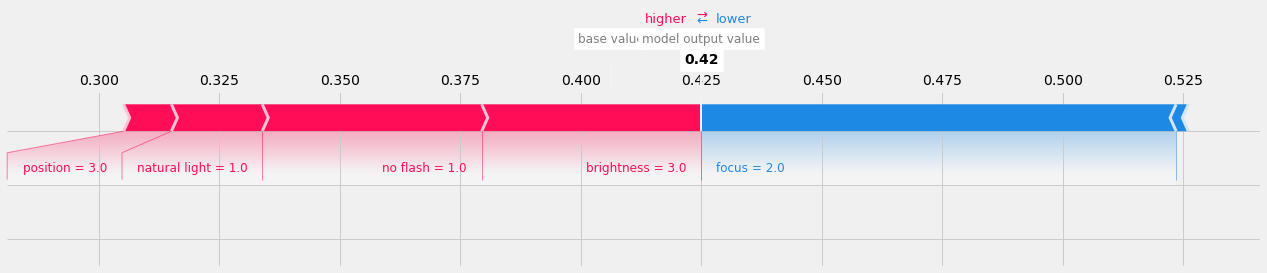

No.9
care


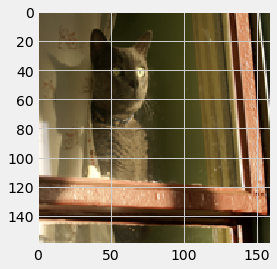

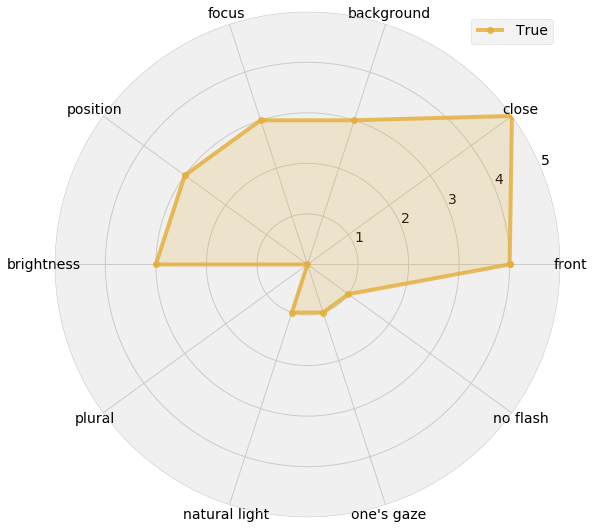

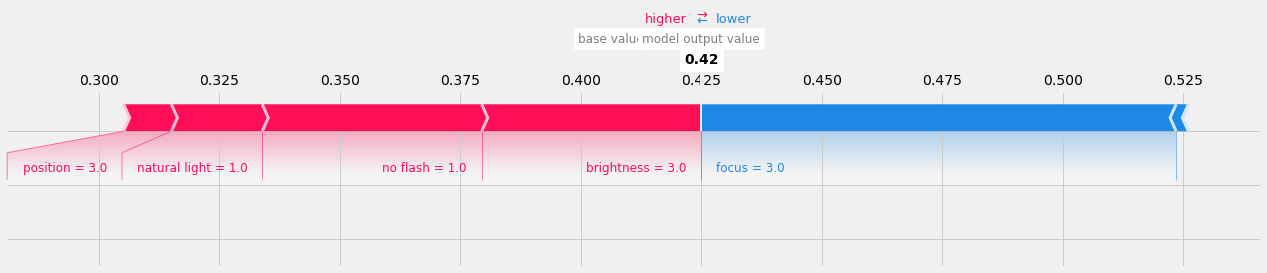

In [25]:
#実際のラベルを表示する
last_predict_dt(X2,Y2,X)

## 5, 保護有無の予想

In [26]:
#小モデルの予想結果を大モデルに投入して保護有無を予想する
model = pickle.load(open("model/model_dt.sav","rb"))
X_pred = np.squeeze(np.array([i.tolist() for i in pred_list]).T)
pred = model.predict(np.array([[np.squeeze(np.array(j)) for j in i] for i in X_pred]))

print("base_acc:" + str(accuracy_score(np.zeros(len(pred)),np.squeeze(care_valid)))[:4])
print("acc:" + str(accuracy_score(pred,np.squeeze(care_valid)))[:4])
print()
print("confusion_matrix:")
cm = ConfusionMatrix(pred,np.squeeze(care_valid))
cm.print_matrix()

base_acc:0.63
acc:0.56

confusion_matrix:
Predict  0        1        
Actual
0        56       32       

1        20       12       




Setting feature_perturbation = "tree_path_dependent" because no background data was given.


care(true):0
care(pred):0


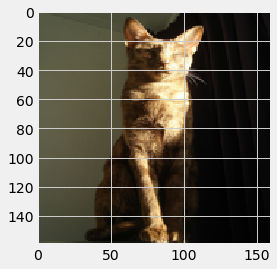

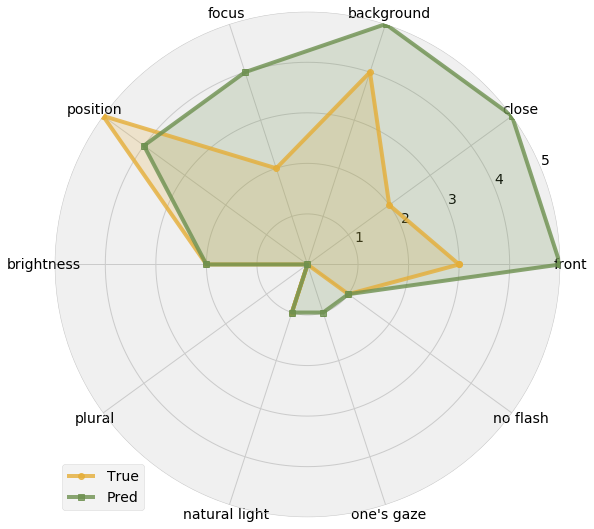

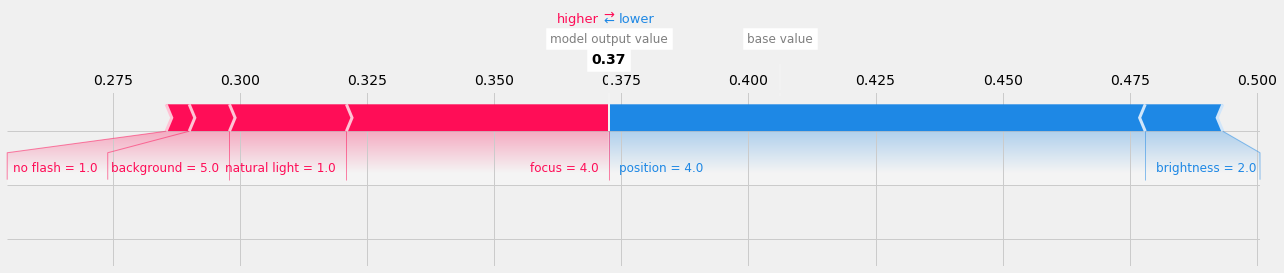

care(true):1
care(pred):0


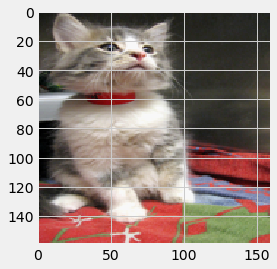

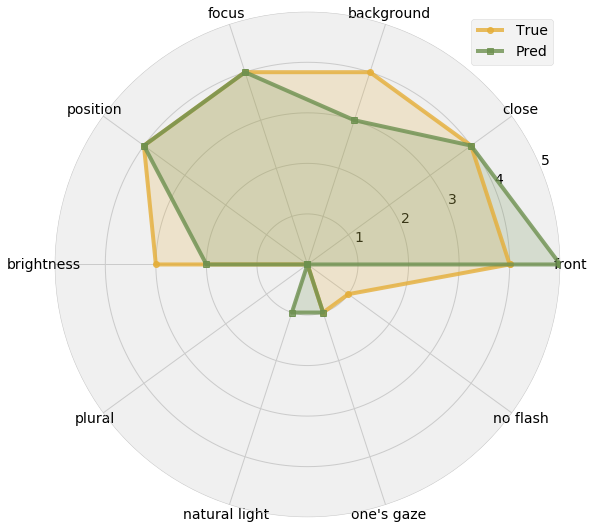

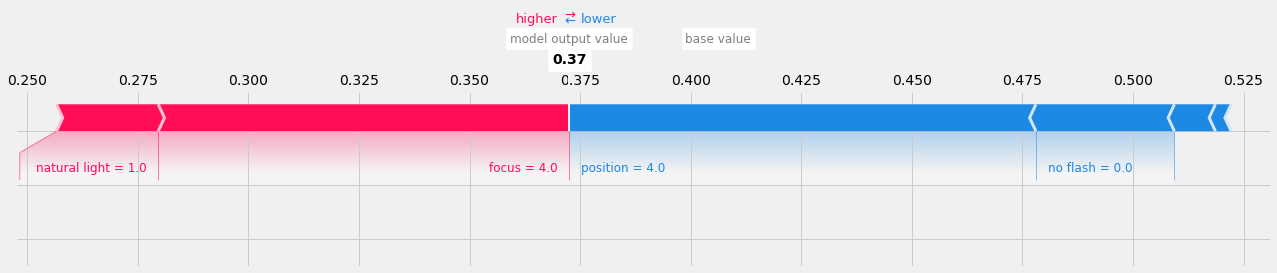

care(true):0
care(pred):0


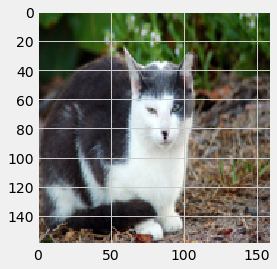

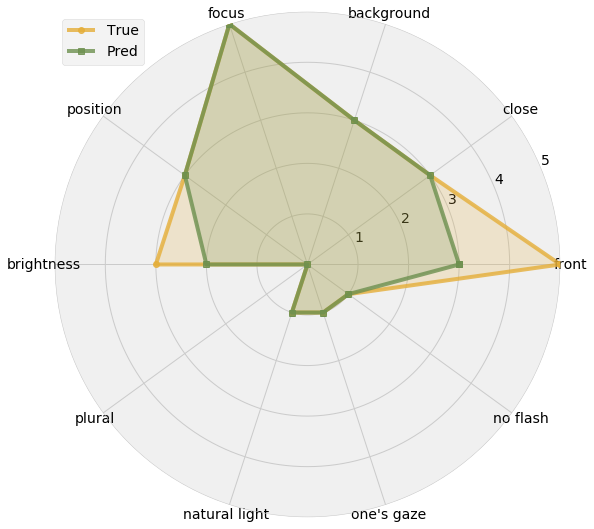

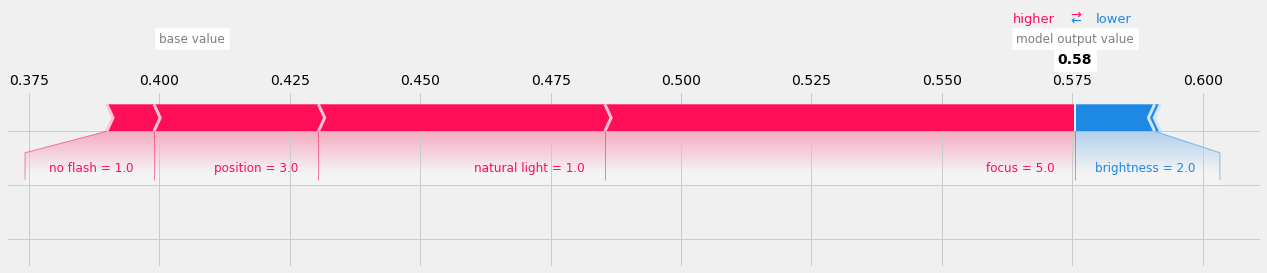

care(true):0
care(pred):1


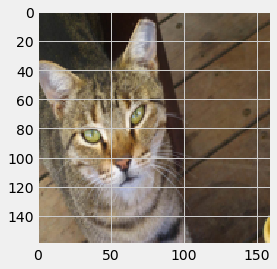

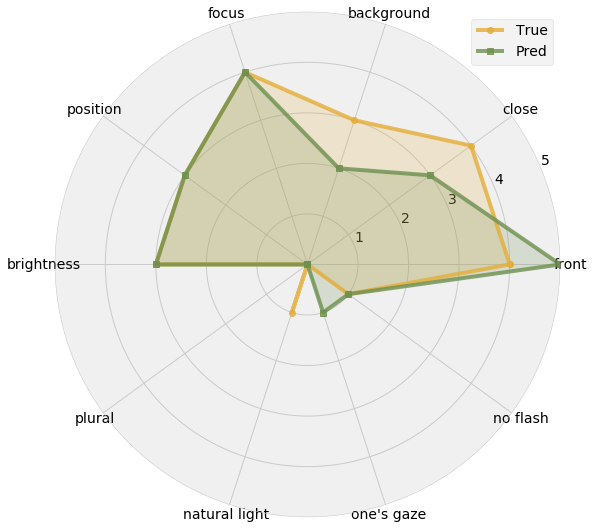

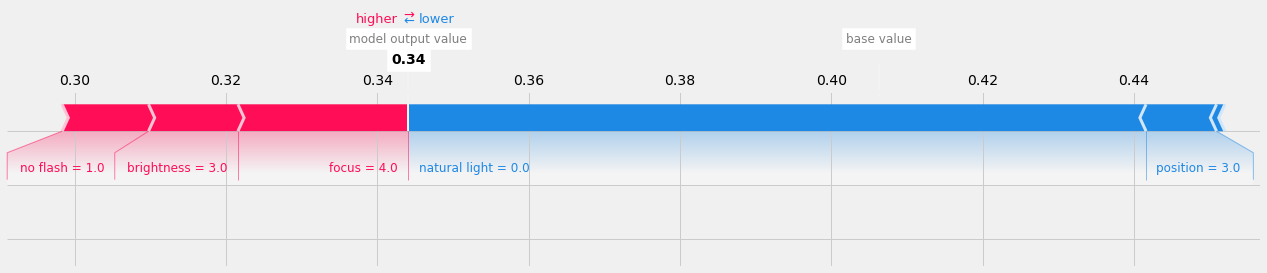

care(true):1
care(pred):0


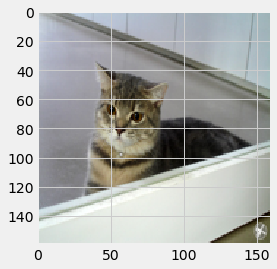

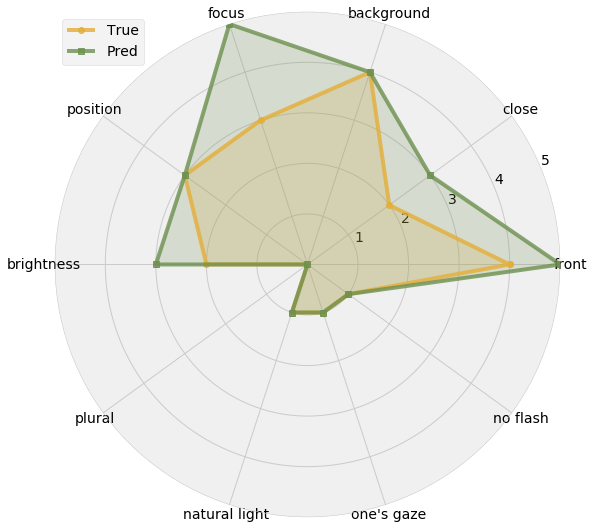

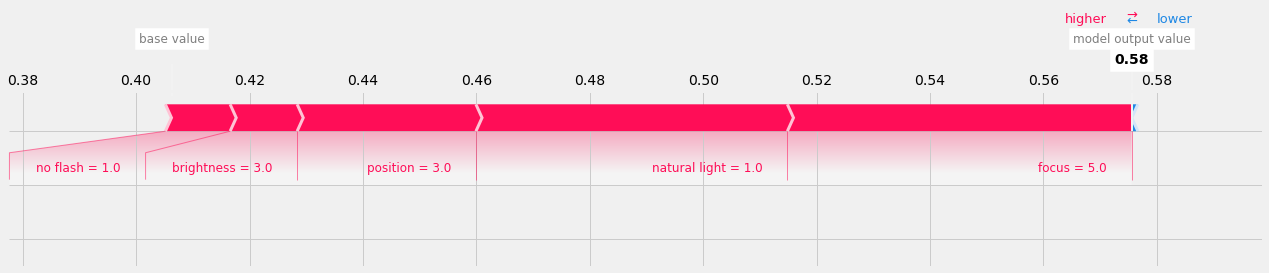

care(true):0
care(pred):0


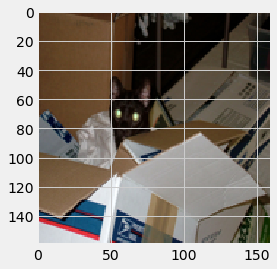

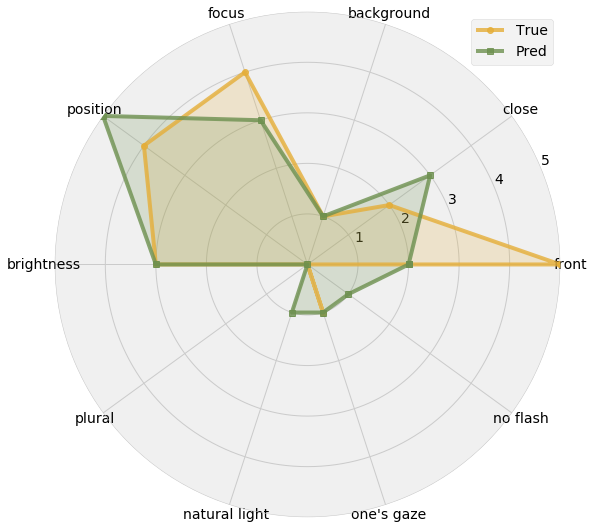

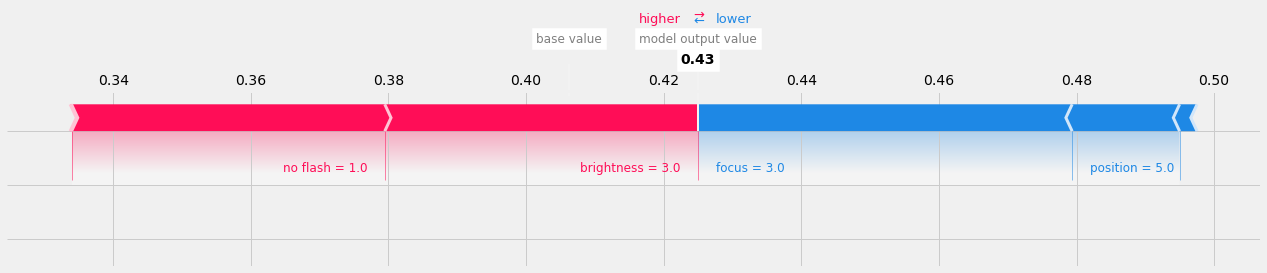

care(true):1
care(pred):0


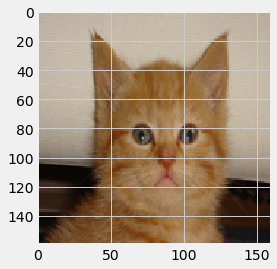

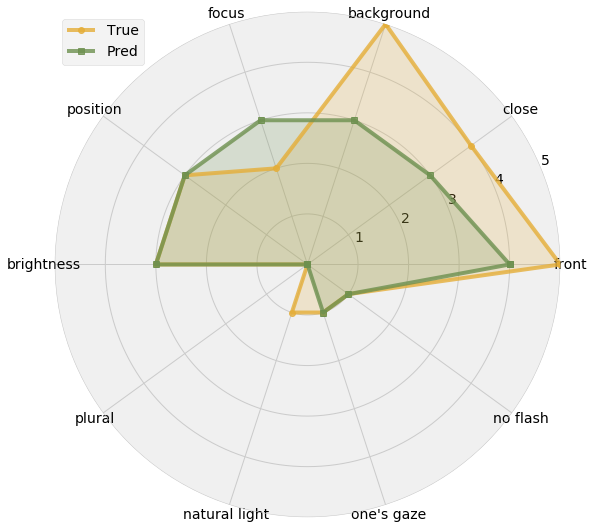

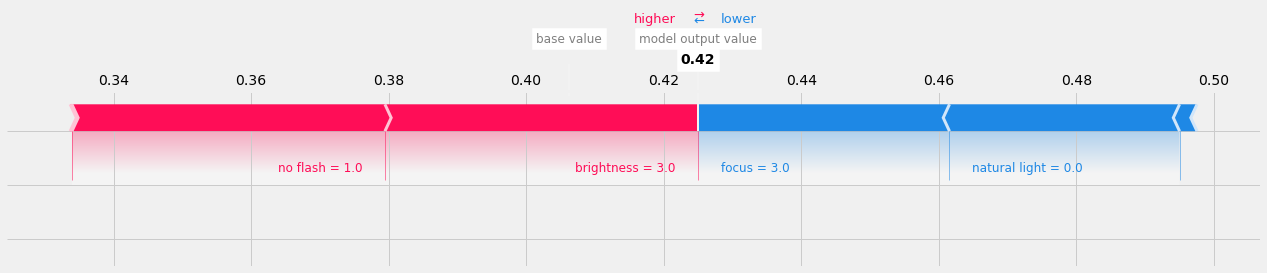

care(true):0
care(pred):0


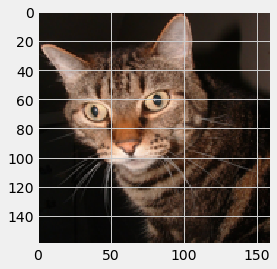

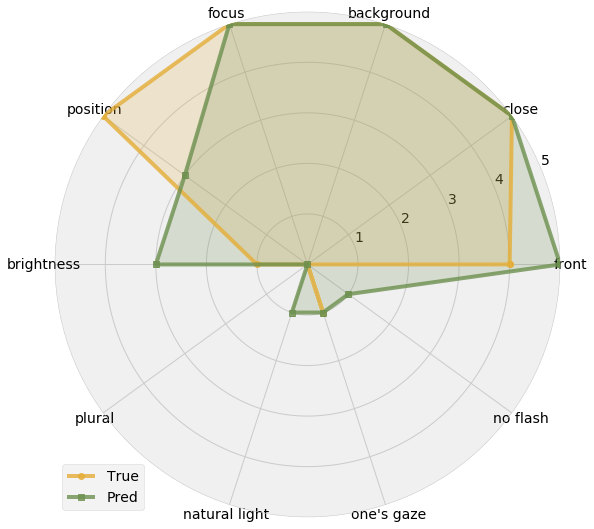

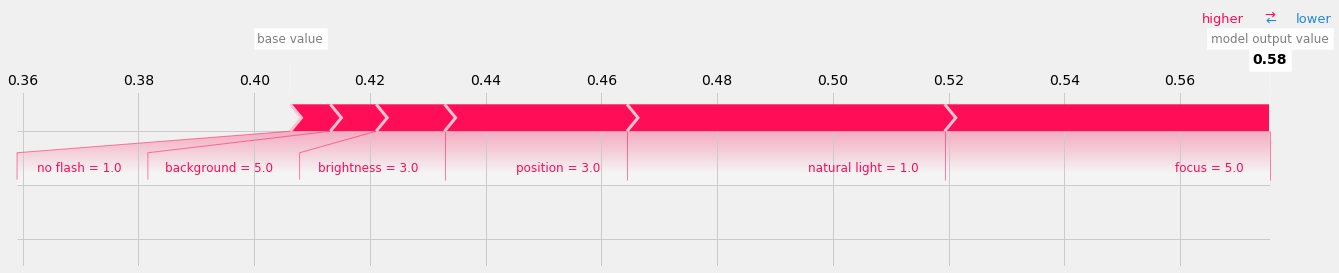

care(true):0
care(pred):0


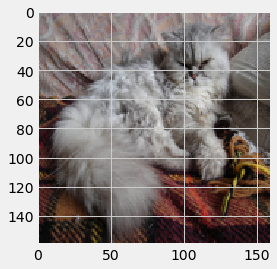

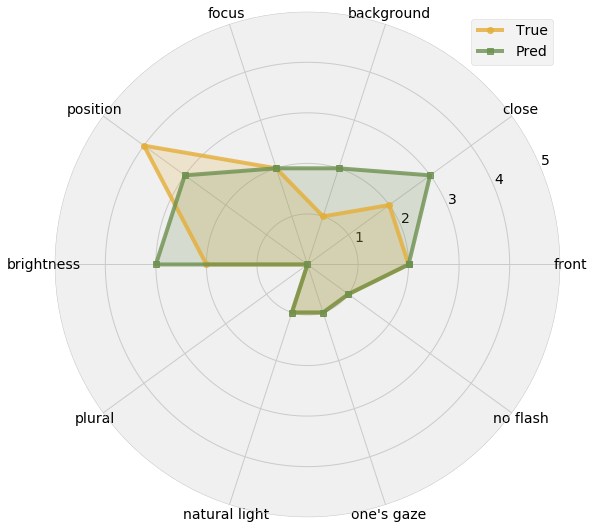

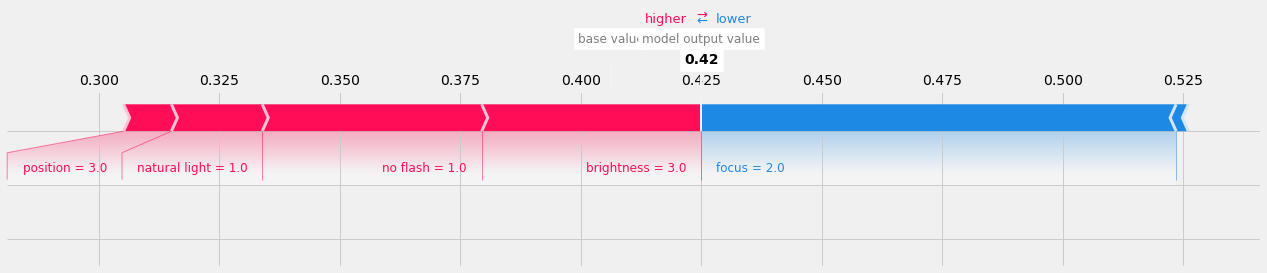

care(true):1
care(pred):0


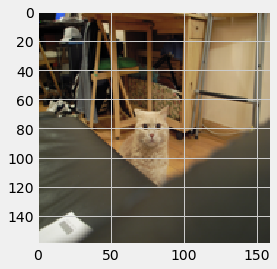

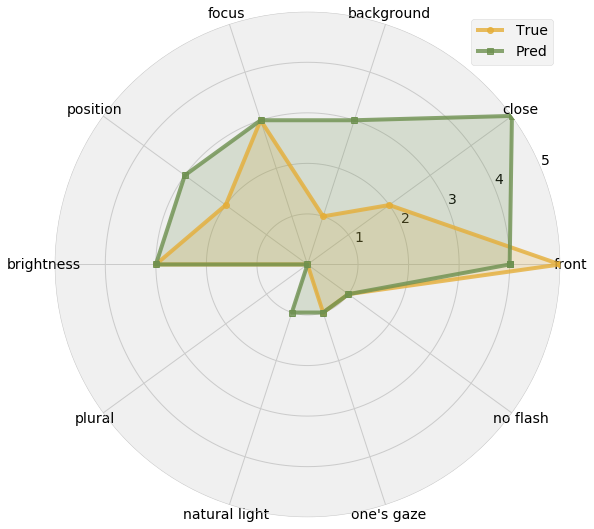

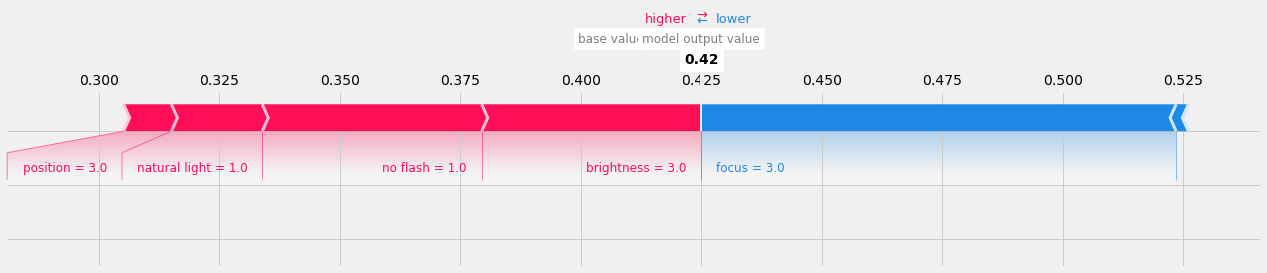

In [27]:
explainer = shap.TreeExplainer(model)
sample_num = 10
for i in range(sample_num):
    print("=" * 50)
    print("care(true):" + str(np.squeeze(care_valid)[i]))
    print("care(pred):" + str(pred[i]))
    
    #画像
    plt.imshow(X_valid[i])
    plt.show()
    
    #レーダーチャート
    plot_polar(["front","close","background","focus","position","brightness","plural","natural light","one's gaze","no flash"], y_valid[i], np.squeeze(X2.loc[[i]].values))
    
    #SHAP
    shap_values = explainer.shap_values(X2)
    shap.force_plot(explainer.expected_value[1], 
                shap_values[1][i],
                X2.loc[[i]], 
                matplotlib=True,
                )

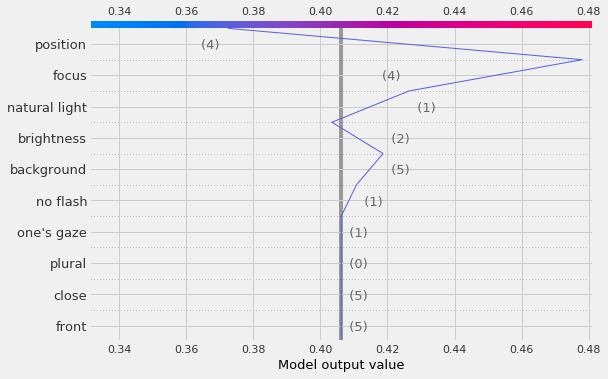

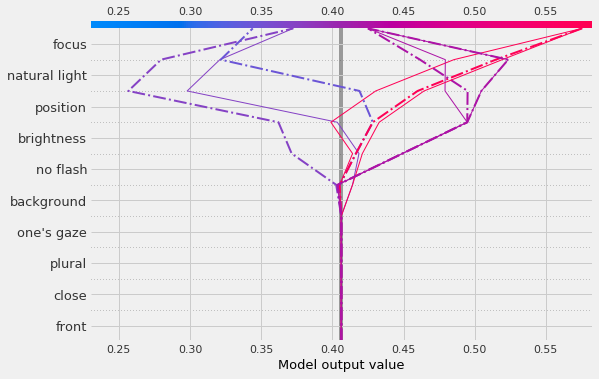

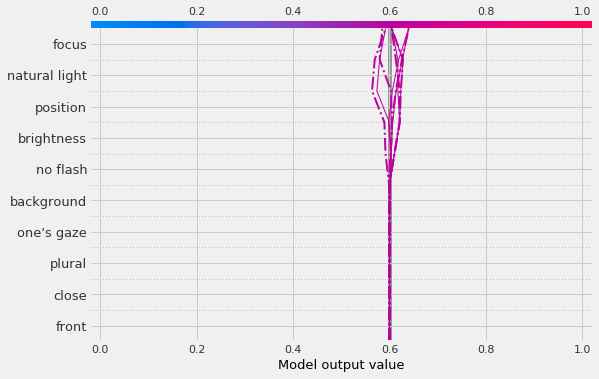

In [28]:
sample_num = 10

#予想が外れたら点線で表示
misclassified = (pred[0:sample_num] != np.squeeze(care_valid)[0:sample_num])

#サンプルが1つの場合
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:1], X2[0:1])

#サンプルが複数の場合
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:sample_num], X2[0:sample_num],highlight=misclassified)

#オッズ比を確率に
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:sample_num], X2[0:sample_num], link='logit', highlight=misclassified)